In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

In [2]:
mode_weights = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/modes_weights.csv',index_col=0,delim_whitespace=False,header=0)

mode_weights

#mode_weights=mode_weights.drop(15,axis=0)
#mode_weights=mode_weights.drop(14,axis=0)

meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19']

x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/xlabels_EP.txt',delim_whitespace=True,header=None)
x_labels=x_labels.values.flatten().tolist()+mode_weights.columns.tolist()

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/ylabels.txt',delim_whitespace=True,header=None)



all_input = []
all_output=[]
all_x=[]
for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    modeweights = np.tile(mode_weights.iloc[i,:].values, (inputData.shape[0],1))
    input_modes = np.concatenate((inputData,modeweights),axis=1)
    all_x.append(torch.tensor(inputData))
    all_input.append(torch.tensor(input_modes))
    all_output.append(torch.tensor(outputData))
    print(val)
    print(np.max(outputData))
#all_input=pd.concat(all_input)
#all_output=pd.concat(all_output
#all_input.columns=x_labels
#all_output.columns=y_labels

01
406.703
02
317.407
03
332.914
04
309.14
05
277.849
06
296.377
07
355.546
08
283.103
09
391.145
10
439.316
11
348.01
12
292.465
13
301.222
14
325.678
15
320.459
16
297.968
17
317.709
18
297.346
19
312.492


In [3]:
train_input=[]
test_input = []
train_output=[]
test_output = []

train_input_modes=[]
test_input_modes = []
train_output_modes=[]
test_output_modes = []

for i in range(len(meshes)):

    X=all_x[i]
    y=all_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input.append(X_train)
    test_input.append(X_test)
    train_output.append(y_train)
    test_output.append(y_test)
    
for i in range(len(meshes)):

    X=all_input[i]
    y=all_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input_modes.append(X_train)
    test_input_modes.append(X_test)
    train_output_modes.append(y_train)
    test_output_modes.append(y_test)


# Emulator per mesh

In [4]:
emulators=[]
for i in range(len(meshes)):
    emulators.append(GPE.ensemble(train_input[i],train_output[i],mean_func="linear",training_iter=1000))

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


In [5]:
reps=1

In [6]:
R2 = torch.zeros(len(meshes),2)
R2_std = torch.zeros(len(meshes),2)
for i in range(len(meshes)):
    meanR, stdR = emulators[i].R2_sample(test_input[i],test_output[i],n=1000)
    R2[i,:]=meanR
    R2_std[i,:] = stdR

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:208: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  prediction=torch.stack(prediction).T
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone(

In [7]:
R2.mean(axis=1)

tensor([0.9983, 0.9977, 0.9984, 0.9986, 0.9992, 0.9982, 0.9988, 0.9975, 0.9982,
        0.9949, 0.9978, 0.9970, 0.9987, 0.9984, 0.9968, 0.9966, 0.9980, 0.9975,
        0.9987])

In [8]:
R2_std

tensor([[0.0003, 0.0006],
        [0.0002, 0.0011],
        [0.0002, 0.0005],
        [0.0002, 0.0004],
        [0.0003, 0.0002],
        [0.0002, 0.0005],
        [0.0002, 0.0004],
        [0.0004, 0.0008],
        [0.0005, 0.0004],
        [0.0002, 0.0017],
        [0.0003, 0.0012],
        [0.0007, 0.0008],
        [0.0003, 0.0004],
        [0.0001, 0.0008],
        [0.0003, 0.0019],
        [0.0007, 0.0015],
        [0.0004, 0.0008],
        [0.0010, 0.0004],
        [0.0004, 0.0006]])

In [9]:
plt.rcParams["figure.figsize"] = (10,5)
fontS=12


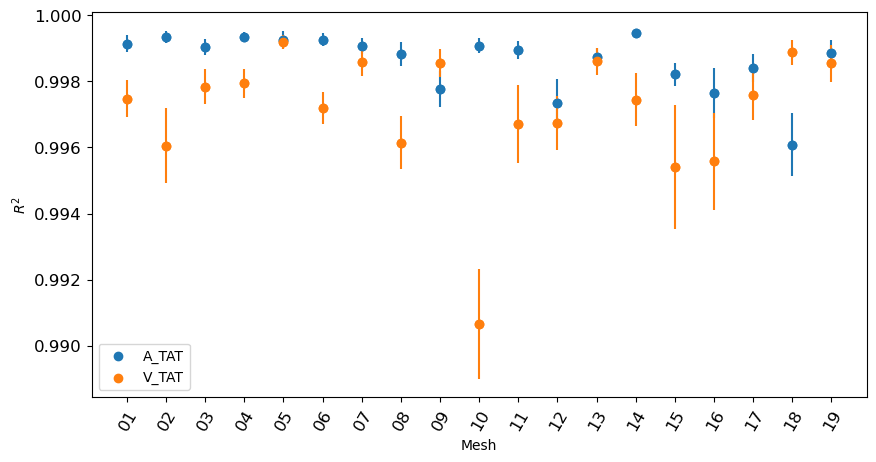

In [10]:
fig, ax = plt.subplots()


ax.scatter(meshes,R2[:,0].detach().numpy())
plt.errorbar(meshes,R2[:,0].detach().numpy(),fmt='o',yerr=R2_std[:,0].detach().numpy())
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

ax.scatter(meshes,R2[:,1].detach().numpy())
plt.errorbar(meshes,R2[:,1].detach().numpy(),fmt='o',yerr=R2_std[:,1].detach().numpy())
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Mesh')
plt.ylabel('$R^2$')
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('WeavingDTIndivEm.pdf' )

In [11]:
nn=[20,40,60,80,100,120,140]

In [12]:
R2 = torch.zeros(len(meshes),len(nn),2)
R2_std = torch.zeros(len(meshes),len(nn),2)
reps=5
for i in range(len(meshes)):
    for j in range(len(nn)):
        for k in range(reps):
            X=train_input[i]
            y=train_output[i]
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y,
                train_size=nn[j],
                random_state=k
            )
            emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)
            meanR, stdR = emulator.R2_sample(test_input[i],test_output[i],n=1000)
            R2[i,j,:]+=meanR/reps
            R2_std[i,j,:] += stdR/reps

0
1


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


(0.7, 1.01)

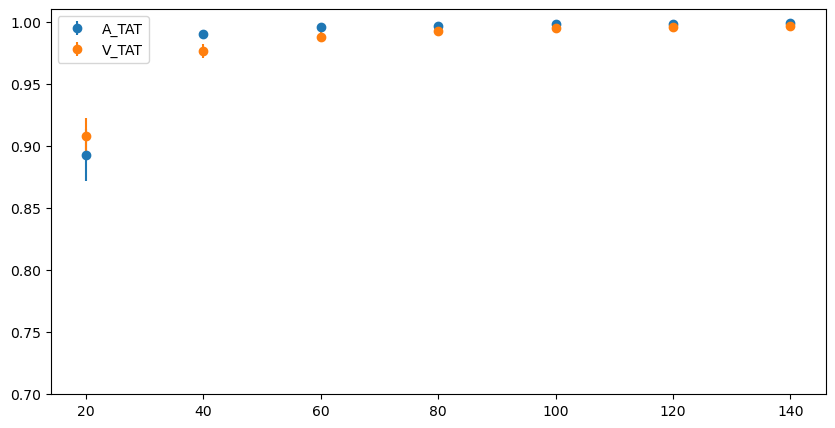

In [13]:
plt.errorbar(nn,R2.mean(axis=0)[:,0].detach().numpy(),fmt='o',yerr=R2_std.mean(axis=0)[:,0].detach().numpy())
plt.errorbar(nn,R2.mean(axis=0)[:,1].detach().numpy(),fmt='o',yerr=R2_std.mean(axis=0)[:,1].detach().numpy())
plt.legend(('A_TAT','V_TAT'))
plt.ylim(0.7,1.01)

In [14]:
nn

[20, 40, 60, 80, 100, 120, 140]

In [15]:
R2.mean(axis=0)[:]

tensor([[0.8927, 0.9081],
        [0.9901, 0.9763],
        [0.9954, 0.9880],
        [0.9969, 0.9925],
        [0.9979, 0.9945],
        [0.9983, 0.9958],
        [0.9986, 0.9968]])

# Emulator trained with 17/18 meshes and evaluated on the left out mesh

In [16]:
np.linspace(100,800,8)

array([100., 200., 300., 400., 500., 600., 700., 800.])

In [17]:
reps = 5
train_p = np.linspace(100,800,8)
R2_test = torch.zeros(len(train_p),reps,2)
R2_leftout= torch.zeros(len(train_p),reps,2)
for i in range(len(train_p)):
    for j in range(reps):
        X=torch.cat(train_input_modes[0:17])[:,0:15]
        y=torch.cat(train_output_modes[0:17])
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            train_size=int(train_p[i]),
            random_state=j
        )
        emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)
        meanR, stdR = emulator.R2_sample(torch.cat(test_input_modes[0:17])[:,0:15],torch.cat(test_output_modes[0:17]),1000)
        
        R2_test[i,j,:]+=meanR
        
        meanR, stdR=emulator.R2_sample(test_input_modes[17][:,0:15],test_output_modes[17],1000) 
        R2_leftout[i,j,:] = meanR
        print(R2_test)

0
1
tensor([[[0.9714, 0.9586],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [

1
tensor([[[0.9714, 0.9586],
         [0.9675, 0.9600],
         [0.9713, 0.9530],
         [0.9781, 0.9596],
         [0.9731, 0.9383]],

        [[0.9878, 0.9762],
         [0.9886, 0.9771],
         [0.9884, 0.9783],
         [0.9893, 0.9788],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9714, 0.9586],
         [0.9675, 0.9600],
         [0.9713, 0.9530],
         [0.9781, 0.9596],
         [0.9731, 0.9383]],

        [[0.9878, 0.9762],
         [0.9886, 0.9771],
         [0.9884, 0.9783],
         [0.9893, 0.9788],
         [0.9898, 0.9760]],

        [[0.9922, 0.9857],
         [0.9934, 0.9857],
         [0.9936, 0.9853],
         [0.9946, 0.9831],
         [0.9933, 0.9864]],

        [[0.9935, 0.9901],
         [0.9951, 0.9884],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9714, 0.9586],
         [0.9675, 0.9600],
         [0.9713, 0.9530],
         [0.9781, 0.9596],
         [0.9731, 0.9383]],

        [[0.9878, 0.9762],
         [0.9886, 0.9771],
         [0.9884, 0.9783],
         [0.9893, 0.9788],
         [0.9898, 0.9760]],

        [[0.9922, 0.9857],
         [0.9934, 0.9857],
         [0.9936, 0.9853],
         [0.9946, 0.9831],
         [0.9933, 0.9864]],

        [[0.9935, 0.9901],
         [0.9951, 0.9884],
         [0.9961, 0.9888],
         [0.9962, 0.9906],
         [0.9956, 0.9914]],

        [[0.9959, 0.9921],
         [0.9966, 0.9921],
         [0.9968, 0.9925],
         [0.9971, 0.9940],
         [0.9970, 0.9927]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9714, 0.9586],
         [0.9675, 0.9600],
         [0.9713, 0.9530],
         [0.9781, 0.9596],
         [0.9731, 0.9383]],

        [[0.9878, 0.9762],
         [0.9886, 0.9771],
         [0.9884, 0.9783],
         [0.9893, 0.9788],
         [0.9898, 0.9760]],

        [[0.9922, 0.9857],
         [0.9934, 0.9857],
         [0.9936, 0.9853],
         [0.9946, 0.9831],
         [0.9933, 0.9864]],

        [[0.9935, 0.9901],
         [0.9951, 0.9884],
         [0.9961, 0.9888],
         [0.9962, 0.9906],
         [0.9956, 0.9914]],

        [[0.9959, 0.9921],
         [0.9966, 0.9921],
         [0.9968, 0.9925],
         [0.9971, 0.9940],
         [0.9970, 0.9927]],

        [[0.9966, 0.9936],
         [0.9969, 0.9927],
         [0.9966, 0.9936],
         [0.9972, 0.9952],
         [0.9970, 0.9941]],

        [[0.9971, 0.9943],
         [0.9971, 0.9944],
         [0.9974, 0.9946],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

In [18]:
reps = 5
train_p = np.linspace(100,800,8)
R2_test = torch.zeros(len(train_p),reps,len(meshes),2)
R2_leftout= torch.zeros(len(train_p),reps,len(meshes),2)
for k in range(len(train_p)):
    for i in range(len(meshes)):
        for j in range(reps):
            X=torch.cat(train_input_modes[0:i]+train_input_modes[i+1:])[:,0:15]
            y=torch.cat(train_output_modes[:i]+train_output_modes[i+1:])
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y,
                train_size=int(train_p[k]),
                random_state=j
            )
            X_test= torch.cat(test_input_modes[0:i]+test_input_modes[i+1:])[:,0:15]
            y_test=torch.cat(test_output_modes[:i]+test_output_modes[i+1:])
            emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

            meanR, stdR = meanR, stdR = emulator.R2_sample(X_test,y_test,1000)
            R2_test[k,j,i,:]=meanR

            meanR, stdR=emulator.R2_sample(test_input_modes[i][:,0:15],test_output_modes[i],1000) 
            R2_leftout[k,j,i,:] = meanR
            print(R2_test[k,j,i,:])
            print(R2_leftout[k,j,i,:])

0
1
tensor([0.9667, 0.9569])
tensor([0.3452, 0.0843])
0
1
tensor([0.9525, 0.9651])
tensor([0.7088, 0.8330])
0
1
tensor([0.9500, 0.9614])
tensor([0.8902, 0.7622])
0
1
tensor([0.9365, 0.9476])
tensor([0.0708, 0.7870])
0
1
tensor([0.9537, 0.9313])
tensor([0.3825, 0.8512])
0
1
tensor([0.9666, 0.9555])
tensor([0.8779, 0.5128])
0
1
tensor([0.9441, 0.9621])
tensor([0.2754, 0.2718])
0
1
tensor([0.9213, 0.9600])
tensor([-0.7956,  0.9429])
0
1
tensor([0.9138, 0.9543])
tensor([-1.4595,  0.7099])
0
1
tensor([0.9582, 0.9274])
tensor([0.5649, 0.9060])
0
1
tensor([0.9562, 0.9559])
tensor([0.5710, 0.5901])
0
1
tensor([0.9271, 0.9682])
tensor([0.7121, 0.6120])
0
1
tensor([0.9589, 0.9566])
tensor([0.7401, 0.7675])
0
1
tensor([0.9421, 0.9568])
tensor([0.6785, 0.7703])
0
1
tensor([0.9579, 0.9471])
tensor([0.9120, 0.6272])
0
1
tensor([0.9634, 0.9562])
tensor([-0.4408, -0.0565])
0
1
tensor([0.9384, 0.9642])
tensor([-1.3677, -0.1270])
0
1
tensor([0.9540, 0.9500])
tensor([ 0.7644, -0.0345])
0
1
tensor([0.9437

1
tensor([0.9856, 0.9846])
tensor([0.9675, 0.9668])
0
1
tensor([0.9842, 0.9781])
tensor([0.7179, 0.9755])
0
1
tensor([0.9881, 0.9813])
tensor([0.9513, 0.9516])
0
1
tensor([0.9875, 0.9740])
tensor([0.9742, 0.9663])
0
1
tensor([0.9845, 0.9779])
tensor([0.8569, 0.7266])
0
1
tensor([0.9854, 0.9830])
tensor([0.8099, 0.8642])
0
1
tensor([0.9852, 0.9753])
tensor([0.7630, 0.7578])
0
1
tensor([0.9894, 0.9811])
tensor([0.6989, 0.1554])
0
1
tensor([0.9877, 0.9714])
tensor([0.7681, 0.6869])
0
1
tensor([0.9847, 0.9769])
tensor([0.8214, 0.8590])
0
1
tensor([0.9854, 0.9783])
tensor([0.8595, 0.6269])
0
1
tensor([0.9838, 0.9783])
tensor([0.7747, 0.6052])
0
1
tensor([0.9872, 0.9823])
tensor([0.5721, 0.7206])
0
1
tensor([0.9874, 0.9758])
tensor([0.8474, 0.7598])
0
1
tensor([0.9894, 0.9801])
tensor([0.6738, 0.7980])
0
1
tensor([0.9877, 0.9810])
tensor([0.6483, 0.6932])
0
1
tensor([0.9850, 0.9805])
tensor([0.5352, 0.7139])
0
1
tensor([0.9906, 0.9823])
tensor([0.6305, 0.6550])
0
1
tensor([0.9909, 0.9796])
t

1
tensor([0.9953, 0.9905])
tensor([-2.8371,  0.1376])
0
1
tensor([0.9958, 0.9909])
tensor([-3.0253,  0.1591])
0
1
tensor([0.9958, 0.9900])
tensor([-3.8539,  0.7544])
0
1
tensor([0.9956, 0.9915])
tensor([0.9762, 0.9147])
0
1
tensor([0.9945, 0.9909])
tensor([0.5590, 0.9624])
0
1
tensor([0.9951, 0.9918])
tensor([0.5981, 0.9215])
0
1
tensor([0.9955, 0.9922])
tensor([0.5452, 0.9593])
0
1
tensor([0.9955, 0.9916])
tensor([0.4690, 0.9496])
0
1
tensor([0.9950, 0.9920])
tensor([0.8015, 0.9627])
0
1
tensor([0.9944, 0.9905])
tensor([0.9354, 0.9818])
0
1
tensor([0.9948, 0.9906])
tensor([0.7849, 0.8990])
0
1
tensor([0.9956, 0.9910])
tensor([0.8150, 0.9688])
0
1
tensor([0.9952, 0.9897])
tensor([0.8208, 0.9757])
0
1
tensor([0.9956, 0.9900])
tensor([0.8877, 0.9561])
0
1
tensor([0.9941, 0.9908])
tensor([0.8845, 0.9265])
0
1
tensor([0.9947, 0.9906])
tensor([0.9520, 0.8906])
0
1
tensor([0.9958, 0.9917])
tensor([0.9660, 0.9272])
0
1
tensor([0.9954, 0.9890])
tensor([0.9759, 0.8782])
0
1
tensor([0.9947, 0.99

1
tensor([0.9967, 0.9934])
tensor([0.7739, 0.7507])
0
1
tensor([0.9963, 0.9940])
tensor([0.9579, 0.8023])
0
1
tensor([0.9964, 0.9941])
tensor([0.9792, 0.8079])
0
1
tensor([0.9962, 0.9918])
tensor([0.7520, 0.8036])
0
1
tensor([0.9968, 0.9944])
tensor([0.7992, 0.8090])
0
1
tensor([0.9965, 0.9932])
tensor([0.9122, 0.7833])
0
1
tensor([0.9963, 0.9926])
tensor([-0.6592,  0.9186])
0
1
tensor([0.9961, 0.9915])
tensor([-2.1824,  0.6725])
0
1
tensor([0.9958, 0.9919])
tensor([-0.1917,  0.6616])
0
1
tensor([0.9968, 0.9941])
tensor([-1.7529,  0.7081])
0
1
tensor([0.9961, 0.9934])
tensor([0.3933, 0.4898])
0
1
tensor([0.9960, 0.9919])
tensor([0.8535, 0.9537])
0
1
tensor([0.9964, 0.9913])
tensor([0.5742, 0.9449])
0
1
tensor([0.9961, 0.9920])
tensor([0.3711, 0.9417])
0
1
tensor([0.9964, 0.9935])
tensor([0.8065, 0.9476])
0
1
tensor([0.9966, 0.9923])
tensor([0.4899, 0.9069])
0
1
tensor([0.9963, 0.9924])
tensor([0.4725, 0.8639])
0
1
tensor([0.9960, 0.9898])
tensor([0.1244, 0.8802])
0
1
tensor([0.9959, 0.

1
tensor([0.9971, 0.9952])
tensor([0.8943, 0.8021])
0
1
tensor([0.9974, 0.9937])
tensor([0.9780, 0.7673])
0
1
tensor([0.9971, 0.9944])
tensor([0.9723, 0.7330])
0
1
tensor([0.9971, 0.9951])
tensor([0.9357, 0.7687])
0
1
tensor([0.9972, 0.9939])
tensor([0.9185, 0.8112])
0
1
tensor([0.9974, 0.9952])
tensor([0.9379, 0.7147])
0
1
tensor([0.9974, 0.9936])
tensor([0.9331, 0.7444])
0
1
tensor([0.9972, 0.9944])
tensor([0.9325, 0.7891])
0
1
tensor([0.9974, 0.9949])
tensor([0.6766, 0.7208])
0
1
tensor([0.9975, 0.9939])
tensor([0.4666, 0.7278])
0
1
tensor([0.9970, 0.9954])
tensor([0.9210, 0.8880])
0
1
tensor([0.9975, 0.9940])
tensor([0.9672, 0.8340])
0
1
tensor([0.9971, 0.9940])
tensor([0.8688, 0.9259])
0
1
tensor([0.9974, 0.9954])
tensor([0.4112, 0.8122])
0
1
tensor([0.9974, 0.9943])
tensor([0.9179, 0.9303])
0
1
tensor([0.9970, 0.9956])
tensor([0.9565, 0.7333])
0
1
tensor([0.9975, 0.9947])
tensor([0.9148, 0.9087])
0
1
tensor([0.9973, 0.9941])
tensor([0.9564, 0.6540])
0
1
tensor([0.9978, 0.9947])
t

1
tensor([0.9979, 0.9956])
tensor([0.4348, 0.8924])
0
1
tensor([0.9974, 0.9956])
tensor([0.0159, 0.8994])
0
1
tensor([0.9972, 0.9956])
tensor([-0.3033,  0.9060])
0
1
tensor([0.9977, 0.9956])
tensor([-0.0912,  0.9000])


In [19]:
i

18

In [20]:
meanR

tensor([-0.0912,  0.9000])

In [21]:
R2_leftout.mean(axis=[1,2])[:8].detach()

tensor([[ 0.4859,  0.7612],
        [ 0.4449,  0.7915],
        [ 0.3483,  0.7629],
        [ 0.1232,  0.7866],
        [ 0.3140,  0.7787],
        [-0.0562,  0.8120],
        [ 0.2519,  0.8131],
        [ 0.3006,  0.8112]])

In [22]:
R2_test.mean(axis=[1,2])[:8]

tensor([[0.9512, 0.9511],
        [0.9859, 0.9783],
        [0.9925, 0.9868],
        [0.9950, 0.9909],
        [0.9962, 0.9929],
        [0.9968, 0.9940],
        [0.9974, 0.9947],
        [0.9977, 0.9954]])

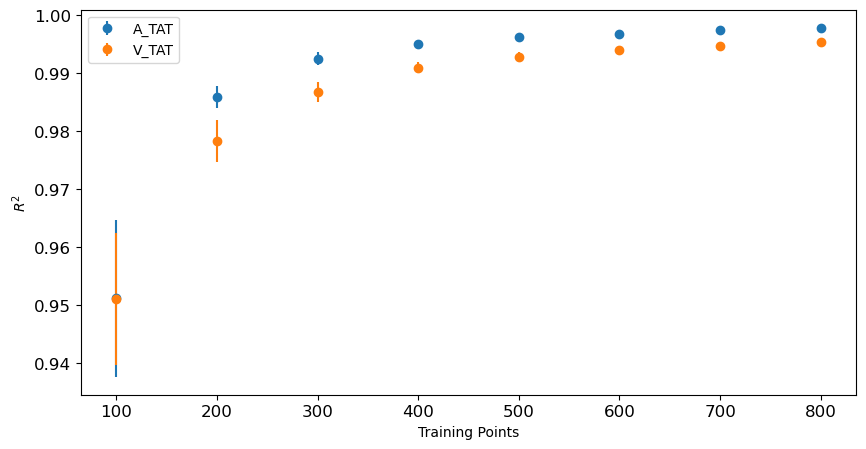

In [23]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(train_p[:8],R2_test.mean(axis=[1,2])[:8,0].detach().numpy(),fmt='o',yerr=R2_test.std(axis=[1,2])[:8,0].detach().numpy())
plt.errorbar(train_p[:8],R2_test.mean(axis=[1,2])[:8,1].detach().numpy(),fmt='o',yerr=R2_test.std(axis=[1,2])[:8,1].detach().numpy())
plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Training Points')
plt.ylabel('$R^2$')
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('WeavingDTLatentNLeftin.pdf' )

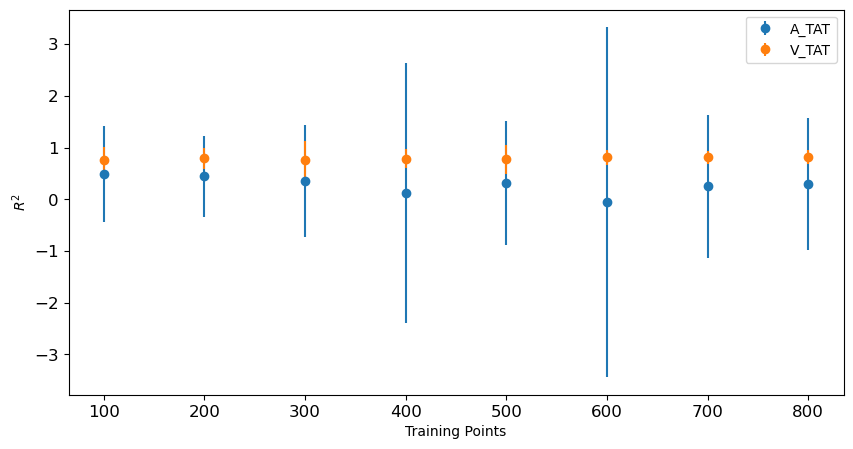

In [24]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(train_p[:8],R2_leftout.mean(axis=[1,2])[:8,0].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=[1,2])[:8,0].detach().numpy())
plt.errorbar(train_p[:8],R2_leftout.mean(axis=[1,2])[:8,1].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=[1,2])[:8,1].detach().numpy())
plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Training Points')
plt.ylabel('$R^2$')
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('WeavingDTLatentNLeftout.pdf' )

Text(0, 0.5, '$R^2$')

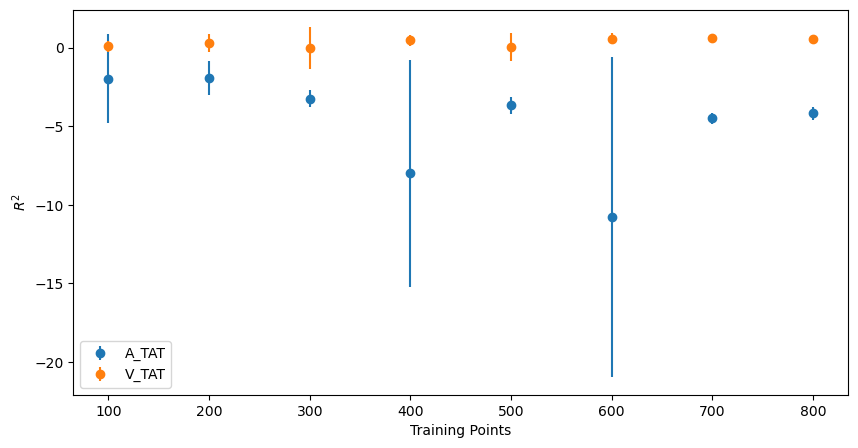

In [25]:
fig, ax = plt.subplots()
me=3

#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(train_p[:8],R2_leftout[:,:,me].mean(axis=1)[:8,0].detach().numpy(),fmt='o',yerr=R2_leftout[:,:,me].std(axis=1)[:8,0].detach().numpy())
plt.errorbar(train_p[:8],R2_leftout[:,:,me].mean(axis=1)[:8,1].detach().numpy(),fmt='o',yerr=R2_leftout[:,:,me].std(axis=1)[:8,1].detach().numpy())
plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Training Points')
plt.ylabel('$R^2$')

In [26]:
train_p

array([100., 200., 300., 400., 500., 600., 700., 800.])

In [27]:
R2_leftout.mean(axis=1).shape

torch.Size([8, 19, 2])

In [28]:
R2_leftout.mean(axis=1)[7,:,0]

tensor([ 0.8005, -1.6450,  0.6517, -4.1916,  0.6179,  0.8330,  0.9139,  0.9603,
         0.7625,  0.6778,  0.8791,  0.9814,  0.8909,  0.8147,  0.7057,  0.8858,
        -0.4045,  0.4726,  0.1051])

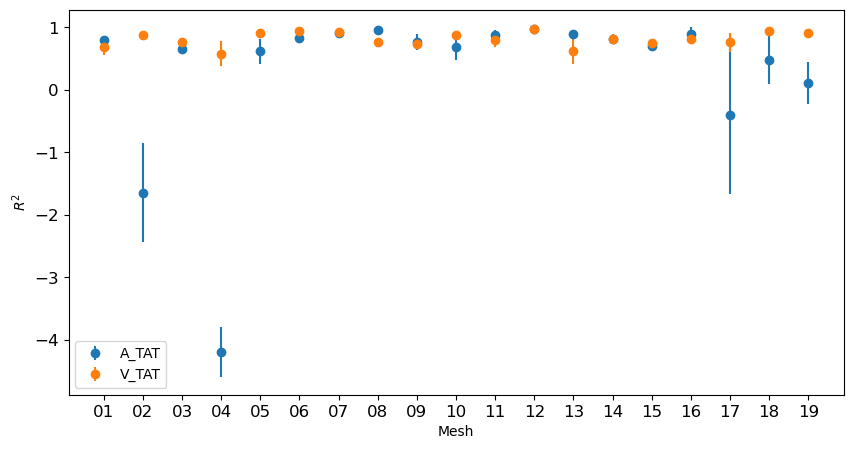

In [29]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(meshes,R2_leftout.mean(axis=1)[7,:,0].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=1)[7,:,0].detach().numpy())
plt.errorbar(meshes,R2_leftout.mean(axis=1)[7,:,1].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=1)[7,:,1].detach().numpy())
plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Mesh')
plt.ylabel('$R^2$')
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('WeavingDTLatent800Leftout.pdf' )

In [30]:
all_output[3][0]

tensor([120.8960, 119.6680], dtype=torch.float64)

In [31]:
comp=17

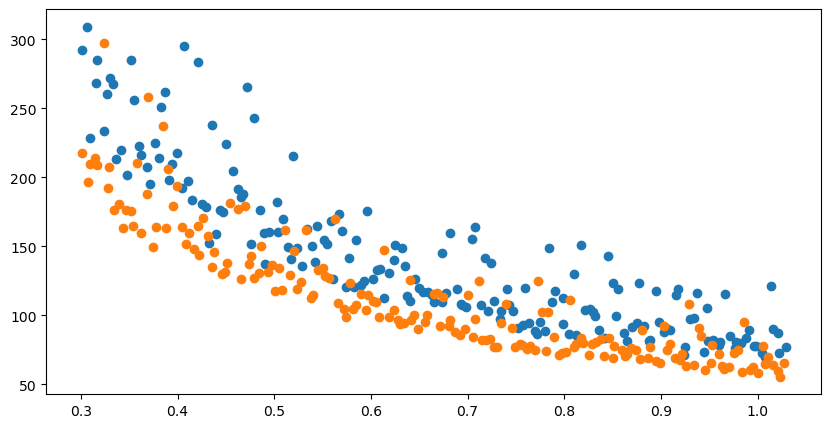

In [32]:
plt.plot(all_input[3][:,3],all_output[3][:,0],'o')
plt.plot(all_input[comp][:,3],all_output[comp][:,0],'o')

In [33]:
test_input_modes[3][6:15][0]

tensor([  0.7487,   0.2863,   2.9323,   0.3908,   0.4751,   2.8957, -15.0770,
         28.8892,   8.6449,   4.7580,   1.3011,   5.9833, -12.7411,  29.4289,
          0.9004,  -3.1176,   5.3607,  -4.3849,  -5.0521,  -0.3224,   1.7646,
          0.2812,   0.3799,   1.4111], dtype=torch.float64)

In [34]:
check=7

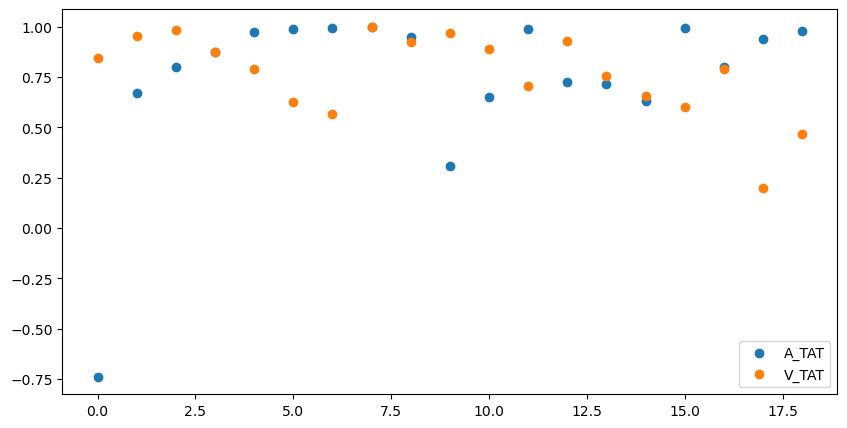

In [35]:
r2check = torch.zeros(len(meshes),2)
for i in range(len(meshes)):
    #print(torch.sum(torch.abs(test_input_modes[check][6:15][0]-test_input_modes[i][6:15][0])))
    r2check[i]=emulators[i].R2(test_input[check],test_output[check])

r2check=r2check.detach().numpy()
plt.plot(r2check,'o')
plt.legend(('A_TAT','V_TAT'))

[]

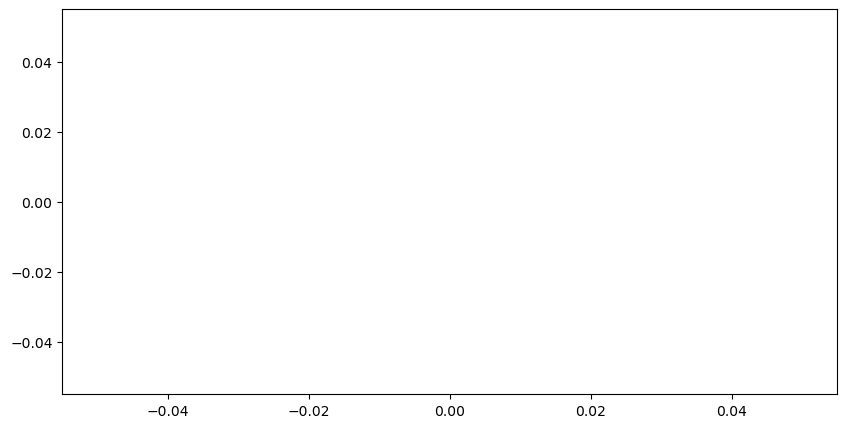

In [36]:
plt.plot()

In [37]:
for i in range(len(meshes)):
    print(torch.sum(torch.abs(test_input_modes[3][6:15][0]-test_input_modes[i][6:15][0])))
    print()

tensor(224.9606, dtype=torch.float64)

tensor(167.3161, dtype=torch.float64)

tensor(203.0570, dtype=torch.float64)

tensor(0., dtype=torch.float64)

tensor(230.9404, dtype=torch.float64)

tensor(241.2827, dtype=torch.float64)

tensor(221.6740, dtype=torch.float64)

tensor(197.9337, dtype=torch.float64)

tensor(257.0497, dtype=torch.float64)

tensor(222.4901, dtype=torch.float64)

tensor(259.4040, dtype=torch.float64)

tensor(257.9458, dtype=torch.float64)

tensor(191.6570, dtype=torch.float64)

tensor(233.2693, dtype=torch.float64)

tensor(210.3870, dtype=torch.float64)

tensor(176.0385, dtype=torch.float64)

tensor(201.6297, dtype=torch.float64)

tensor(227.6242, dtype=torch.float64)

tensor(211.0256, dtype=torch.float64)



Text(0, 0.5, '$R^2$')

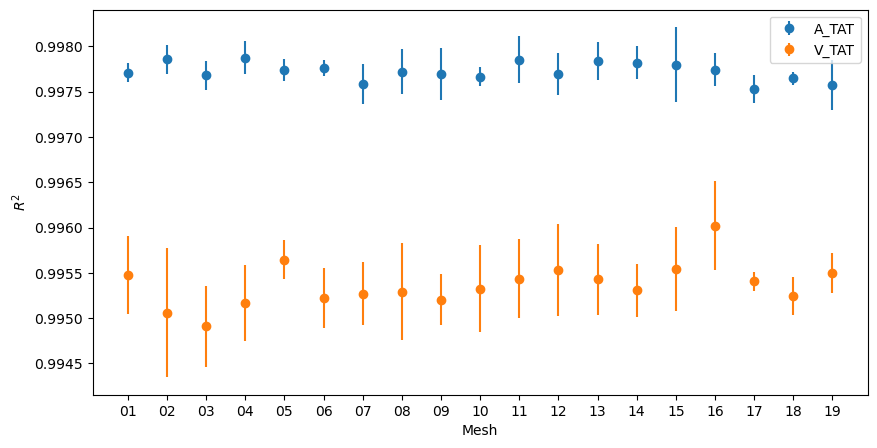

In [38]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(meshes,R2_test.mean(axis=1)[7,:,0].detach().numpy(),fmt='o',yerr=R2_test.std(axis=1)[7,:,0].detach().numpy())
plt.errorbar(meshes,R2_test.mean(axis=1)[7,:,1].detach().numpy(),fmt='o',yerr=R2_test.std(axis=1)[7,:,1].detach().numpy())
plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Mesh')
plt.ylabel('$R^2$')

In [39]:
reps = 5

R2_test = torch.zeros(len(meshes),reps,2)
R2_leftout= torch.zeros(len(meshes),reps,2)
for i in range(len(meshes)):
    for j in range(reps):
        X=torch.cat(train_input_modes[0:i]+train_input_modes[i+1:])[:,0:15]
        y=torch.cat(train_output_modes[:i]+train_output_modes[i+1:])
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            train_size=800,
            random_state=j+1
        )
        X_test= torch.cat(test_input_modes[0:i]+test_input_modes[i+1:])[:,0:15]
        y_test=torch.cat(test_output_modes[:i]+test_output_modes[i+1:])
        emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)
        
        meanR, stdR = emulator.R2_sample(X_test,y_test,1000)
        
        R2_test[i,j,:]=meanR
        
        meanR, stdR=emulator.R2_sample(test_input_modes[i][:,0:15],test_output_modes[i],1000) 
        R2_leftout[i,j,:] = meanR
        print(R2_test)

0
1


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


tensor([[[0.9979, 0.9952],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.00

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

1
tensor([[[0.9979, 0.9952],
         [0.9975, 0.9956],
         [0.9978, 0.9950],
         [0.9979, 0.9950],
         [0.9976, 0.9948]],

        [[0.9981, 0.9956],
         [0.9978, 0.9955],
         [0.9979, 0.9951],
         [0.9980, 0.9949],
         [0.9977, 0.9946]],

        [[0.9978, 0.9952],
         [0.9978, 0.9952],
         [0.9977, 0.9948],
         [0.9979, 0.9950],
         [0.9974, 0.9947]],

        [[0.9981, 0.9953],
         [0.9977, 0.9957],
         [0.9979, 0.9955],
         [0.9980, 0.9947],
         [0.9978, 0.9941]],

        [[0.9978, 0.9957],
         [0.9978, 0.9961],
         [0.9979, 0.9955],
         [0.9979, 0.9957],
         [0.9979, 0.9957]],

        [[0.9977, 0.9951],
         [0.9977, 0.9954],
         [0.9977, 0.9953],
         [0.9977, 0.9945],
         [0.9975, 0.9941]],

        [[0.9980, 0.9949],
         [0.9977, 0.9952],
         [0.9978, 0.9956],
         [0.9978, 0.9947],
         [0.9979, 0.9945]],

        [[0.9978, 0.9945],
         [0.

In [ ]:
reps = 5

R2_test = torch.zeros(len(meshes),reps,2)
R2_leftout= torch.zeros(len(meshes),reps,2)
for i in range(len(meshes)):
    Xs=[]
    Ys=[]
    for j in range(reps):
        for k in range(len(meshes)):
            if k!=i:
                X=train_input_modes[k][:,0:15]
                y=train_output_modes[k]
                X_train, X_test, y_train, y_test = train_test_split(
                    X,
                    y,
                    train_size=50,
                    random_state=j+k
                )
                Xs.append(X_train)
                Ys.append(y_train)

        X_train=torch.cat(Xs,)
        y_train=torch.cat(Ys,)
        print(X_train.shape)
        X_test= torch.cat(test_input_modes[0:i]+test_input_modes[i+1:])[:,0:15]
        y_test=torch.cat(test_output_modes[:i]+test_output_modes[i+1:])
        emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=2000)
        
        meanR, stdR = emulator.R2_sample(X_test,y_test,1000)
        
        R2_test[i,j,:]=meanR
        
        meanR, stdR=emulator.R2_sample(test_input_modes[i][:,0:15],test_output_modes[i],1000) 
        R2_leftout[i,j,:] = meanR
        print(R2_test)

torch.Size([900, 15])
0
1


/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/operators/_linear_operator.py:2155: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


tensor([[[0.9600, 0.9834],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.00

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4625552892684937 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.132591724395752 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.2636395692825317 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6473190784454346 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.50166654586792 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4260333776474 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8873008489608765 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5388680696487427 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.3985919952392578 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6744064092636108 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.3569025993347168 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.3480974435806274 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4573060274124146 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.9107714891433716 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4176381826400757 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4635027647018433 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.576833724975586 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8225234746932983 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.444377064704895 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6371185779571533 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.7063689231872559 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.7205817699432373 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.2448757886886597 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5191341638565063 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.040358543395996 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.1113708019256592 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.7055026292800903 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.590250015258789 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4535964727401733 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8614169359207153 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6837986707687378 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6590244770050049 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.1814661026000977 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.9955815076828003 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.098736047744751 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.0656936168670654 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.109492778778076 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5453342199325562 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6988216638565063 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5973553657531738 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.636654257774353 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4316247701644897 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4557311534881592 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5346603393554688 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.9298774003982544 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.488921880722046 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.4601852893829346 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.9552130699157715 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.96168053150177 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.485431432723999 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_c

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8249999284744263 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.3471405506134033 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.1809585094451904 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.3675389289855957 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.0906982421875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.2378876209259033 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_c

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.599606513977051 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.150935649871826 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.4695777893066406 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.2665677070617676 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.863990306854248 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8193697929382324 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.3577566146850586 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.9705203771591187 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.90520441532135 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.166551113128662 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_c

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5500988960266113 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.408113956451416 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8022621870040894 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.9696682691574097 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.3177716732025146 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.139662742614746 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.5972177982330322 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.0201966762542725 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.6597909927368164 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6432651281356812 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.3269760608673096 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.7008895874023438 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8746856451034546 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4507784843444824 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.542941093444824 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6428333520889282 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.764437198638916 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.059222936630249 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.0800249576568604 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.072842597961426 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.653366804122925 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.5544016361236572 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.9018019437789917 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.9571053981781006 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.440981388092041 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.2544667720794678 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.34871244430542 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.940629005432129 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_c

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.862474203109741 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.46105694770813 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_c

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.7393381595611572 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.4818081855773926 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.187544822692871 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.317514657974243 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.998687982559204 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.986786961555481 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.1288719177246094 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.8180861473083496 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.303006410598755 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.539292335510254 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.42568039894104 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.6160287857055664 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.3397390842437744 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.907826542854309 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.1229066848754883 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.782360315322876 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.5476036071777344 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.627467393875122 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.560633659362793 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.493461847305298 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.635056257247925 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.695089101791382 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.9707884788513184 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.2239181995391846 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

1
tensor([[[0.9600, 0.9834],
         [0.9689, 0.9896],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.2309849262237549 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.2950711250305176 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6434425115585327 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6272257566452026 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.43466317653656 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.724473714828491 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_c

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.696707248687744 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.2652459144592285 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.286790609359741 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.1485595703125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.5306379795074463 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.252901315689087 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.134185552597046 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.2749907970428467 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.3678207397460938 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.608421802520752 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 6.34311056137085 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.5289604663848877 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.7736666202545166 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 5.209377765655518 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.92536735534668 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 5.566519737243652 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_c

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.781339645385742 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.948731422424316 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.098584175109863 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.9209136962890625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 7.8342204093933105 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.305229663848877 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.440654277801514 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 6.199103832244873 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.7486555576324463 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.906189441680908 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.500860214233398 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.495929718017578 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 5.273263454437256 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 7.305157661437988 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 9.946061134338379 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 6.883677959442139 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 7.190942287445068 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 5.413920879364014 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

1


/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.8161091804504395 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.05247494578361511 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/util

tensor([[[ 9.6002e-01,  9.8342e-01],
         [ 9.6889e-01,  9.8955e-01],
         [-3.4147e+03,  9.1754e-01],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.00

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4473837614059448 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.2865245342254639 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.1568204164505005 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5397361516952515 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5481549501419067 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.1671663522720337 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6081619262695312 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5703572034835815 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.059418797492981 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.2496211528778076 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.1193519830703735 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6838321685791016 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.0258665084838867 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.1420862674713135 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.184004306793213 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.051765203475952 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.1148300170898438 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.7530570030212402 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.3837822675704956 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.096118450164795 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.0781168937683105 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 5.593642711639404 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear

1


/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.1942700147628784 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.39008548855781555 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/l

tensor([[[ 9.6002e-01,  9.8342e-01],
         [ 9.6889e-01,  9.8955e-01],
         [-3.4147e+03,  9.1754e-01],
         [-2.4586e+00,  9.4299e-01],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.00

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.0556652545928955 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6479984521865845 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6098716259002686 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.3801831007003784 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linea

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6179360151290894 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.1454081535339355 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


In [ ]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(meshes,R2_test.mean(axis=1)[:,0].detach().numpy(),fmt='o',yerr=R2_test.std(axis=1)[:,0].detach().numpy())
plt.errorbar(meshes,R2_test.mean(axis=1)[:,1].detach().numpy(),fmt='o',yerr=R2_test.std(axis=1)[:,1].detach().numpy())
plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Mesh')
plt.ylabel('$R^2$')

In [ ]:
len(meshes)

In [ ]:
R2_test.shape

In [ ]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(meshes,R2_leftout.mean(axis=1)[:,0].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=1)[:,0].detach().numpy())
plt.errorbar(meshes,R2_leftout.mean(axis=1)[:,1].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=1)[:,1].detach().numpy())
plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Mesh')
plt.ylabel('$R^2$')
plt.legend(['A_TAT','V_TAT'])

In [ ]:
np.max(np.array(R2_leftout),axis=(0,1))

# Discrepancy

In [5]:
# x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/xlabels_EP.txt',delim_whitespace=True,header=None)

# y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/ylabels.txt',delim_whitespace=True,header=None)

# y_labels

# inputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/01/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
# outputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/01/Y.txt",index_col=None,delim_whitespace=True,header=None).values

# inputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/02/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
# outputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/02/Y.txt",index_col=None,delim_whitespace=True,header=None).values

X0 = train_input[0]
Y0 = train_output[0]
X1 = train_input[1]
Y1 = train_output[1]


for param in emulators[0].models[0].named_parameters():
    print(f' value = {param}')

# split original dataset in training, validation and testing sets
X_train=X0
y_train=Y0
X_test=test_input[0]
y_test=test_output[0]

p = int(X1.shape[0]*0.05)
n = int(X_train.shape[0]/p)
reps = 5
MSE = torch.zeros((n,reps,2))
R2 = torch.zeros((n,reps,2))
MSE_p = torch.zeros((n,reps,2))
R2_p = torch.zeros((n,reps,2))
MSEa = torch.zeros((n,reps,2))
R2a = torch.zeros((n,reps,2))
for i in range(n):
    for j in range(reps):
        a=np.random.choice(range(X_train.shape[0]),(i+1)*p,replace=False)
        m0 = emulators[0].predict(X_train[a,:])
#         y_adjust = torch.tensor(y_train[a] - m0)
#         delta_1 = GPE.ensemble(X_train[a,:],y_adjust,mean_func="linear",training_iter=500)
#         MSE[i,j] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()
#         R2[i,j] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-y_test)**2).mean(axis=0)/y_test.var(axis=0)).detach().numpy()
        
        
        delta_1=GPE.ensemble(X_train[a,:],y_train[a],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators[1:],a=None)
        MSEaM,MSEaSTD = delta_1.MSE_sample(X_test,y_test,1000)
        R2aM,R2aSTD = delta_1.R2_sample(X_test,y_test,1000)
        
        MSE[i,j] += MSEaM
        R2[i,j] += R2aM
        
        
        delta_1=GPE.ensemble(X_train[a,:],y_train[a],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators[1]],a=None)
        MSEaM,MSEaSTD = delta_1.MSE_sample(X_test,y_test,1000)
        R2aM,R2aSTD = delta_1.R2_sample(X_test,y_test,1000)
        
        MSEa[i,j] += MSEaM
        R2a[i,j] += R2aM
        
        delta_1p = GPE.ensemble(X_train[a,:],y_train[a],mean_func="linear",training_iter=500)
        MSEaM,MSEaSTD = delta_1p.MSE_sample(X_test,y_test,1000)
        R2aM,R2aSTD = delta_1p.R2_sample(X_test,y_test,1000)
        
        MSE_p[i,j] += MSEaM
        R2_p[i,j] += R2aM

x = np.linspace(9,162,18)

x

MSE.mean(axis=1)[0]

MSE




 value = ('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-13.0669], requires_grad=True))
 value = ('covar_module.raw_outputscale', Parameter containing:
tensor(0.4679, requires_grad=True))
 value = ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[32.8634, 24.1502, 26.6298,  1.3238,  6.8045,  1.6815]],
       requires_grad=True))
 value = ('mean_module.weights', Parameter containing:
tensor([[ 7.6845e-03],
        [-5.6172e-03],
        [ 1.5326e-03],
        [-1.8826e+00],
        [-2.5208e-01],
        [-6.6706e-01]], requires_grad=True))
 value = ('mean_module.bias', Parameter containing:
tensor([2.4689], requires_grad=True))
0
1


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:208: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  prediction=torch.stack(prediction).T
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:224: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_mean = torch.tensor(MSE_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:225: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0


KeyboardInterrupt: 

In [ ]:
n

In [ ]:
p

In [ ]:
X1.shape[0]

In [9]:
x = np.linspace(7,144,20)

Text(0.5, 0, '$m$')

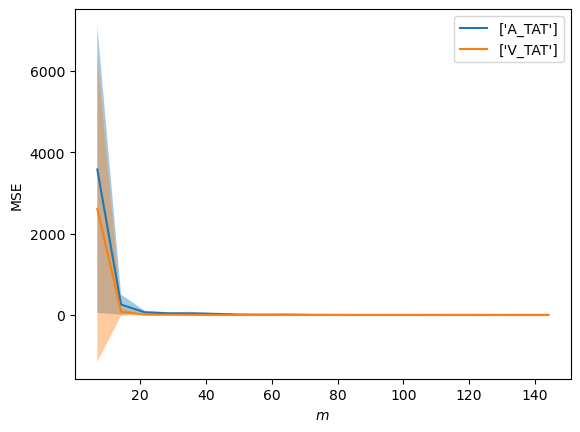

In [10]:
plt.plot(x,MSE.mean(axis=1))
plt.fill_between(x, MSE.mean(axis=1)[:,0]+MSE.std(axis=1)[:,0], y2=MSE.mean(axis=1)[:,0]-MSE.std(axis=1)[:,0],alpha=0.4)
plt.fill_between(x, MSE.mean(axis=1)[:,1]+MSE.std(axis=1)[:,1], y2=MSE.mean(axis=1)[:,1]-MSE.std(axis=1)[:,1],alpha=0.4)
plt.legend(y_labels.values)

plt.ylabel('MSE')
plt.xlabel('$m$')
#plt.yscale('log')


tensor([[[1.0053e+03, 4.4139e+02],
         [3.5017e+03, 9.0324e+02],
         [1.2513e+03, 1.5707e+02],
         [1.2043e+05, 1.0591e+04],
         [1.7407e+03, 9.0006e+01]],

        [[2.0532e+02, 1.6733e+02],
         [5.4058e+02, 7.5744e+01],
         [7.2628e+02, 8.4713e+01],
         [8.1053e+02, 1.7521e+02],
         [1.7129e+03, 7.9795e+01]],

        [[7.4946e+02, 1.7684e+02],
         [1.1037e+02, 4.9126e+01],
         [1.5816e+03, 7.4548e+01],
         [4.3494e+01, 9.8884e+01],
         [6.6827e+01, 1.4606e+02]],

        [[8.6498e+01, 7.5162e+01],
         [8.9355e+01, 7.4566e+01],
         [5.1005e+01, 2.8990e+01],
         [1.2719e+02, 3.4361e+01],
         [8.9162e+01, 3.0088e+01]],

        [[1.2944e+02, 1.7104e+01],
         [5.1697e+01, 1.3738e+01],
         [3.8570e+01, 3.5743e+01],
         [3.3745e+01, 1.3179e+01],
         [7.2499e+01, 2.7964e+01]],

        [[2.1092e+01, 1.8025e+01],
         [3.5971e+01, 1.0903e+01],
         [3.7181e+01, 1.3848e+01],
         [

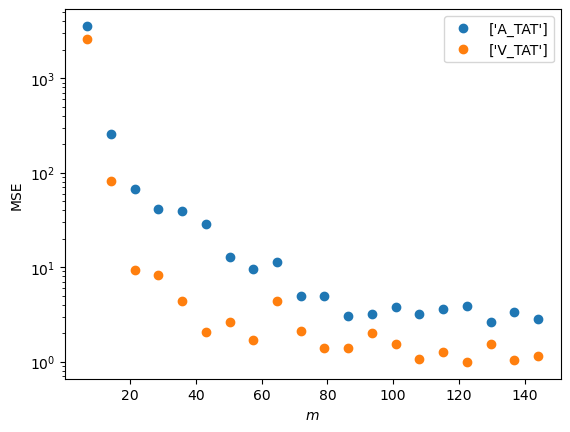

In [11]:
MSE.mean(axis=1)[:,0]+MSE.std(axis=1)[:,0]

MSE.mean(axis=1)[:,0]-MSE.std(axis=1)[:,0]

delta_1p.MSE(X_test,y_test)/reps

plt.plot(x,MSE.mean(axis=1),'o') 
plt.legend(y_labels.values)

plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

np.hstack((MSE_p,MSE))

MSE_p.mean(axis=1)[:,0]+MSE_p.std(axis=1)[:,0]

MSE_p



In [12]:
MSE_p.std(axis=1)

tensor([[5.3029e+04, 4.5698e+03],
        [5.6121e+02, 5.0124e+01],
        [6.6699e+02, 5.2082e+01],
        [2.6961e+01, 2.4030e+01],
        [3.8924e+01, 9.9179e+00],
        [9.8304e+00, 3.0475e+00],
        [4.9026e+00, 5.6294e+00],
        [7.8964e+00, 8.1764e+00],
        [8.7092e+00, 2.1163e+00],
        [5.6862e+00, 2.9046e+00],
        [5.8292e+00, 6.3382e-01],
        [1.9533e+00, 1.6281e+00],
        [2.9756e+00, 6.8957e-01],
        [4.6004e+00, 5.1059e-01],
        [8.1565e-01, 4.7906e-01],
        [1.6409e+00, 3.7506e-01],
        [1.3574e+00, 3.8370e-01],
        [9.7432e-01, 3.0096e-01],
        [3.9897e-01, 5.2850e-01],
        [5.9862e-01, 1.2132e-01]])

In [13]:
MSE_p.mean(axis=1)[1:,0]-MSE_p.std(axis=1)[1:,0]

tensor([ 237.9059, -156.6279,   61.6800,   26.2652,   17.8138,   16.8370,
          12.8005,   11.8472,    6.6968,    8.5121,    6.8649,    5.4093,
           7.8996,    5.7679,    5.8229,    4.2209,    4.5928,    4.6761,
           4.5335])

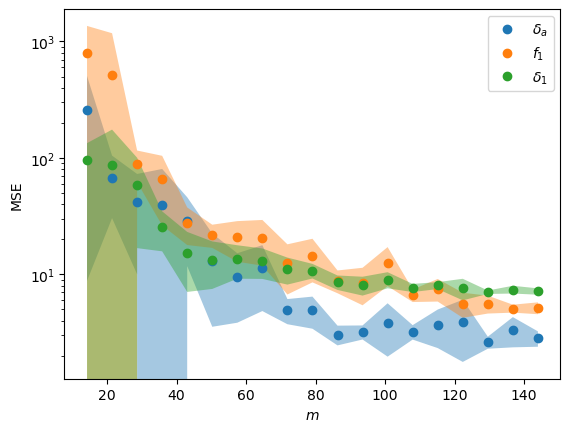

In [14]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1),MSEa.mean(axis=1)))[1:,[0,2,4]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,0]+MSE.std(axis=1)[1:,0], y2=MSE.mean(axis=1)[1:,0]-MSE.std(axis=1)[1:,0],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,0]+MSE_p.std(axis=1)[1:,0], y2=MSE_p.mean(axis=1)[1:,0]-MSE_p.std(axis=1)[1:,0],alpha=0.4)
plt.fill_between(x[1:], MSEa.mean(axis=1)[1:,0]+MSEa.std(axis=1)[1:,0], y2=MSEa.mean(axis=1)[1:,0]-MSEa.std(axis=1)[1:,0],alpha=0.4)
plt.legend(['$\delta_a$','$f_1$','$\delta_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')



In [15]:
R2_p

tensor([[[  0.7694,   0.3104],
         [  0.1963,  -0.4105],
         [  0.7127,   0.7558],
         [-26.6294, -15.5394],
         [  0.6007,   0.8595]],

        [[  0.9535,   0.7383],
         [  0.8762,   0.8811],
         [  0.8316,   0.8678],
         [  0.8151,   0.7263],
         [  0.6067,   0.8759]],

        [[  0.8289,   0.7240],
         [  0.9748,   0.9236],
         [  0.6373,   0.8837],
         [  0.9901,   0.8446],
         [  0.9848,   0.7714]],

        [[  0.9801,   0.8822],
         [  0.9796,   0.8842],
         [  0.9883,   0.9546],
         [  0.9707,   0.9463],
         [  0.9796,   0.9531]],

        [[  0.9703,   0.9735],
         [  0.9881,   0.9782],
         [  0.9908,   0.9448],
         [  0.9922,   0.9793],
         [  0.9829,   0.9563]],

        [[  0.9952,   0.9719],
         [  0.9916,   0.9827],
         [  0.9916,   0.9781],
         [  0.9968,   0.9821],
         [  0.9932,   0.9830]],

        [[  0.9938,   0.9632],
         [  0.9962,   0.985

In [16]:
R2a

tensor([[[ 0.4280, -1.6653],
         [-0.7949,  0.6093],
         [-0.1380,  0.7408],
         [-1.1618,  0.0952],
         [ 0.3337,  0.8395]],

        [[ 0.9749,  0.9596],
         [ 0.9832,  0.8988],
         [ 0.9810,  0.8144],
         [ 0.9646,  0.8687],
         [ 0.9875,  0.9861]],

        [[ 0.9933,  0.8202],
         [ 0.9923,  0.9873],
         [ 0.9960,  0.9785],
         [ 0.9487,  0.9942],
         [ 0.9690,  0.9152]],

        [[ 0.9964,  0.9930],
         [ 0.9907,  0.9944],
         [ 0.9851,  0.9883],
         [ 0.9715,  0.9693],
         [ 0.9898,  0.9788]],

        [[ 0.9909,  0.9945],
         [ 0.9961,  0.9954],
         [ 0.9930,  0.9961],
         [ 0.9962,  0.9943],
         [ 0.9948,  0.9934]],

        [[ 0.9958,  0.9891],
         [ 0.9966,  0.9960],
         [ 0.9975,  0.9949],
         [ 0.9989,  0.9959],
         [ 0.9940,  0.9947]],

        [[ 0.9948,  0.9943],
         [ 0.9982,  0.9897],
         [ 0.9977,  0.9972],
         [ 0.9965,  0.9952],
  

In [17]:
R2

tensor([[[  0.7299, -13.4359],
         [ -0.4653,   0.3035],
         [ -0.9375,  -1.4426],
         [  0.7532,  -1.3478],
         [  0.7942,   0.5478]],

        [[  0.9748,   0.8843],
         [  0.9621,   0.5900],
         [  0.8393,   0.9504],
         [  0.9729,   0.9679],
         [  0.9557,   0.9612]],

        [[  0.9910,   0.9662],
         [  0.9803,   0.9930],
         [  0.9909,   0.9862],
         [  0.9709,   0.9916],
         [  0.9886,   0.9889]],

        [[  0.9972,   0.9931],
         [  0.9828,   0.9924],
         [  0.9957,   0.9945],
         [  0.9942,   0.9855],
         [  0.9826,   0.9708]],

        [[  0.9940,   0.9897],
         [  0.9971,   0.9981],
         [  0.9752,   0.9925],
         [  0.9982,   0.9943],
         [  0.9899,   0.9912]],

        [[  0.9951,   0.9945],
         [  0.9914,   0.9988],
         [  0.9973,   0.9972],
         [  0.9956,   0.9978],
         [  0.9873,   0.9955]],

        [[  0.9929,   0.9978],
         [  0.9978,   0.991

In [18]:
R2

tensor([[[  0.7299, -13.4359],
         [ -0.4653,   0.3035],
         [ -0.9375,  -1.4426],
         [  0.7532,  -1.3478],
         [  0.7942,   0.5478]],

        [[  0.9748,   0.8843],
         [  0.9621,   0.5900],
         [  0.8393,   0.9504],
         [  0.9729,   0.9679],
         [  0.9557,   0.9612]],

        [[  0.9910,   0.9662],
         [  0.9803,   0.9930],
         [  0.9909,   0.9862],
         [  0.9709,   0.9916],
         [  0.9886,   0.9889]],

        [[  0.9972,   0.9931],
         [  0.9828,   0.9924],
         [  0.9957,   0.9945],
         [  0.9942,   0.9855],
         [  0.9826,   0.9708]],

        [[  0.9940,   0.9897],
         [  0.9971,   0.9981],
         [  0.9752,   0.9925],
         [  0.9982,   0.9943],
         [  0.9899,   0.9912]],

        [[  0.9951,   0.9945],
         [  0.9914,   0.9988],
         [  0.9973,   0.9972],
         [  0.9956,   0.9978],
         [  0.9873,   0.9955]],

        [[  0.9929,   0.9978],
         [  0.9978,   0.991

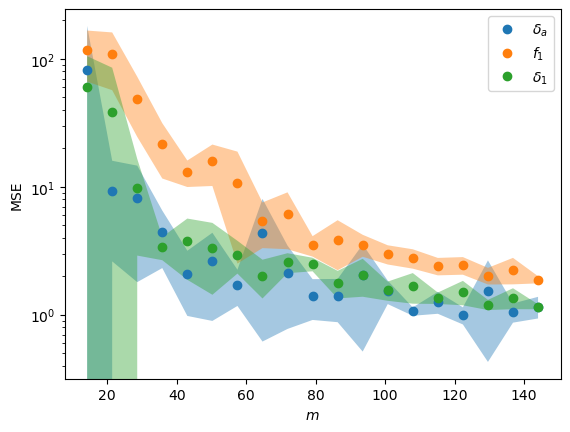

In [19]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1),MSEa.mean(axis=1)))[1:,[1,3,5]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,1]+MSE.std(axis=1)[1:,1], y2=MSE.mean(axis=1)[1:,1]-MSE.std(axis=1)[1:,1],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,1]+MSE_p.std(axis=1)[1:,1], y2=MSE_p.mean(axis=1)[1:,1]-MSE_p.std(axis=1)[1:,1],alpha=0.4)
plt.fill_between(x[1:], MSEa.mean(axis=1)[1:,1]+MSEa.std(axis=1)[1:,1], y2=MSEa.mean(axis=1)[1:,1]-MSEa.std(axis=1)[1:,1],alpha=0.4)
plt.legend(['$\delta_a$','$f_1$','$\delta_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')



In [ ]:
plt.plot(x,np.hstack((R2.mean(axis=1),R2_p.mean(axis=1)))[:,[0,2]],'o') 
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')



In [ ]:
plt.plot(x,np.hstack((R2.mean(axis=1),R2_p.mean(axis=1)))[:,[1,3]],'o') 
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')



In [ ]:
plt.plot(x,MSE_p.mean(axis=1)-MSE.mean(axis=1),'o')




In [ ]:
plt.plot(x,R2_p.mean(axis=1)-R2.mean(axis=1),'o')
plt.legend(y_labels.values)
plt.ylabel('$R^2$')
plt.xlabel('$m$')



In [ ]:
MSE_p

R2_p-R2

plt.plot(x,R2.mean(axis=1),'o')
plt.legend(y_labels.values)
plt.ylabel('$R^2$')
plt.xlabel('$m$')



In [ ]:
delta_1.predict(X_test)

In [5]:
import time

In [6]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score


In [7]:
model = Pipeline(steps=[
    #('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=1, include_bias=False,interaction_only=False)),
    ('lasso', LassoCV(n_alphas=1000,max_iter=10000))
])

In [8]:
def m0_mat(y_test,emulators,x_test,output):

    m0=torch.zeros((y_test.shape[0],len(emulators)))
    for i in range(len(emulators)):
        m0[:,i]=(emulators[i].predict(x_test)[:,output]-y_train.mean(axis=0)[output])/y_train.std(axis=0)[output]


    return m0

In [9]:
def proxy(a,y_train,m0,output):
    m_t = (m0-y_train.mean(axis=0))/y_train.std(axis=0)
    y_t = (y_train-y_train.mean(axis=0))/y_train.std(axis=0)
    a=torch.tensor(a)
    res = ((a*m_t-y_t)**2).mean(axis=0).detach().numpy()
    return res[output]

In [10]:
reps=5
nn=[10,15,20,25,30,35,40,45,50,55,60,80,100,120,140]
R2=torch.zeros(7,len(nn),2,reps)
ISE=torch.zeros(7,len(nn),2,reps)
Ti=torch.zeros(7,len(nn),reps)

for num, n in enumerate(nn):
    for k in range(len(emulators)):
        emulators2=emulators.copy()
        emulators2.pop(k)
        print(len(emulators2))

        X_train = train_input[k]
        y_train = train_output[k]
        X_test = test_input[k]
        y_test = test_output[k]
        
        for i in range(reps):

            #b=np.random.choice(range(X_train.shape[0]),n,replace=False)
            
            X=X_train
            y=y_train 
            X_train1, X_test1, y_train1, y_test1 = train_test_split(
                X,
                y,
                train_size=n,
                random_state=i
            )

            start = time.time()
            model_f=GPE.ensemble(X_train1,y_train1,mean_func="linear",training_iter=500)
            end = time.time()
            R2temp,R2std=model_f.R2_sample(X_test,y_test,1000)
            R2[0,num ,:,i]+=R2temp/(len(emulators))
            ISE[0,num,:,i]+=model_f.ISE(X_test,y_test)/(len(emulators))

            Ti[0,num,i]+=(end-start)/(len(emulators))


            em=np.random.randint(len(emulators2))
            start = time.time()
            model_dc_1 = GPE.ensemble(X_train1,y_train1,mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=torch.tensor([[1],[1]]))
            end = time.time()
            R2temp,R2std=model_dc_1.R2_sample(X_test,y_test,1000)
            R2[1,num ,:,i]+=R2temp/(len(emulators))
            ISE[1,num,:,i]+=model_dc_1.ISE(X_test,y_test)/(len(emulators))
            print(model_dc_1.R2(X_test,y_test))
            print(R2[1])

            Ti[1,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            m0 = emulators2[em].predict(X_train1)
            a_d=np.zeros((y_train.shape[1],1))
            for l in range(y_train.shape[1]):
                result = scipy.optimize.minimize(proxy, 1, args=(y_train1,m0,l), method='Nelder-Mead', tol=1e-8)
                print(result.x)
                a_d[l]=result.x
            a_d=torch.tensor(a_d)
            model_dc_reg = GPE.ensemble(X_train1,y_train1,mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=a_d)
            end = time.time()
            R2temp,R2std=model_dc_reg.R2_sample(X_test,y_test,1000)
            R2[2,num ,:,i]+=R2temp/(len(emulators))
            ISE[2,num,:,i]+=model_dc_reg.ISE(X_test,y_test)/(len(emulators))

            Ti[2,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            model_dc_learned = GPE.ensemble(X_train1,y_train1,mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]])
            end = time.time()
            R2temp,R2std=model_dc_learned.R2_sample(X_test,y_test,1000)
            R2[3,num ,:,i]+=R2temp/(len(emulators))
            ISE[3,num,:,i]+=model_dc_learned.ISE(X_test,y_test)/(len(emulators))

            Ti[3,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            model_dc_all = GPE.ensemble(X_train1,y_train1,mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2)
            end = time.time()
            R2temp,R2std=model_dc_all.R2_sample(X_test,y_test,1000)
            R2[4,num ,:,i]+=R2temp/(len(emulators))
            ISE[4,num,:,i]+=model_dc_all.ISE(X_test,y_test)/(len(emulators))

            Ti[4,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            a_d=torch.zeros((y_train1.shape[1],len(emulators2)))
            for j in range(y_train1.shape[1]):
                m0=m0_mat(y_train1,emulators2,X_train1,j)
                # fit to an order-3 polynomial data
                y_t=(y_train1[:,j]-y_train1.mean(axis=0)[j])/y_train1.std(axis=0)[j]
                model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
                a_d[j]=torch.tensor(model.named_steps['lasso'].coef_)


            model_dc_lasso=GPE.ensemble(X_train1,y_train1,mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d)
            end = time.time()
            R2temp,R2std=model_dc_lasso.R2_sample(X_test,y_test,1000)
            R2[5,num ,:,i]+=R2temp/(len(emulators))
            ISE[5,num,:,i]+=model_dc_lasso.ISE(X_test,y_test)/(len(emulators))

            Ti[5,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            model_dc_lasso_learned=GPE.ensemble(X_train1,y_train1,mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d,a_indicator=True)
            end = time.time()
            R2temp,R2std=model_dc_lasso_learned.R2_sample(X_test,y_test,1000)
            R2[6,num ,:,i]+=R2temp/(len(emulators))
            ISE[6,num,:,i]+=model_dc_lasso_learned.ISE(X_test,y_test)/(len(emulators))

            Ti[6,num,i]+=(end-start)/(len(emulators))

18
0
1


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:208: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  prediction=torch.stack(prediction).T
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone(

0
1
tensor([0.9552, 0.8688], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.0499, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0454, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9629, 0.9253], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.0499, 0.0505, 0.0000, 0.0000, 0.0000],
         [0.0454, 0.0486, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9864, 0.9912], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.0499, 0.0505, 0.0518, 0.0000, 0.0000],
         [0.0454, 0.0486, 0.0521, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9594, 0.9342], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.0499, 0.0505, 0.0518, 0.0499, 0.0000],
         [0.0454, 0.0486, 0.0521, 0.0489, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.6255, 0.7594], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.0499, 0.0505, 0.0518, 0.0499, 0.0326],
         [0.0454, 0.0486, 0.0521, 0.0489, 0.0397]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
18
0
1
0
1
tensor([0.9882, 0.6934], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1019, 0.0505, 0.0518, 0.0499, 0.0326],
         [0.0813, 0.0486, 0.0521, 0.0489, 0.0397]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.000

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.7960, 0.9484], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1019, 0.0919, 0.0518, 0.0499, 0.0326],
         [0.0813, 0.0978, 0.0521, 0.0489, 0.0397]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9180, 0.5819], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1019, 0.0919, 0.1000, 0.0499, 0.0326],
         [0.0813, 0.0978, 0.0826, 0.0489, 0.0397]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.7494, 0.8679], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1019, 0.0919, 0.1000, 0.0859, 0.0326],
         [0.0813, 0.0978, 0.0826, 0.0941, 0.0397]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9312, 0.9868], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1019, 0.0919, 0.1000, 0.0859, 0.0814],
         [0.0813, 0.0978, 0.0826, 0.0941, 0.0915]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
18
0
1
0
1
tensor([0.8359, 0.9575], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1454, 0.0919, 0.1000, 0.0859, 0.0814],
         [0.1312, 0.0978, 0.0826, 0.0941, 0.0915]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.000

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9611, 0.9568], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1454, 0.1422, 0.1000, 0.0859, 0.0814],
         [0.1312, 0.1480, 0.0826, 0.0941, 0.0915]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9675, 0.9875], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1454, 0.1422, 0.1507, 0.0859, 0.0814],
         [0.1312, 0.1480, 0.1345, 0.0941, 0.0915]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9761, 0.9703], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1454, 0.1422, 0.1507, 0.1370, 0.0814],
         [0.1312, 0.1480, 0.1345, 0.1451, 0.0915]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9586, 0.8748], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1454, 0.1422, 0.1507, 0.1370, 0.1318],
         [0.1312, 0.1480, 0.1345, 0.1451, 0.1366]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
18
0
1
0
1
tensor([0.9534, 0.8806], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1944, 0.1422, 0.1507, 0.1370, 0.1318],
         [0.1765, 0.1480, 0.1345, 0.1451, 0.1366]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.000

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.6862, 0.9870], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1944, 0.1779, 0.1507, 0.1370, 0.1318],
         [0.1765, 0.1996, 0.1345, 0.1451, 0.1366]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.4974, 0.9368], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1944, 0.1779, 0.1766, 0.1370, 0.1318],
         [0.1765, 0.1996, 0.1837, 0.1451, 0.1366]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9897, 0.9805], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1944, 0.1779, 0.1766, 0.1890, 0.1318],
         [0.1765, 0.1996, 0.1837, 0.1958, 0.1366]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9293, 0.9246], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.1944, 0.1779, 0.1766, 0.1890, 0.1803],
         [0.1765, 0.1996, 0.1837, 0.1958, 0.1848]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
18
0
1
0
1
tensor([0.9596, 0.9911], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.2447, 0.1779, 0.1766, 0.1890, 0.1803],
         [0.2286, 0.1996, 0.1837, 0.1958, 0.1848]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.000

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9733, 0.8583], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.2447, 0.2290, 0.1766, 0.1890, 0.1803],
         [0.2286, 0.2423, 0.1837, 0.1958, 0.1848]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9014, 0.9884], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.2447, 0.2290, 0.2235, 0.1890, 0.1803],
         [0.2286, 0.2423, 0.2357, 0.1958, 0.1848]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.6555, 0.9703], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.2447, 0.2290, 0.2235, 0.2227, 0.1803],
         [0.2286, 0.2423, 0.2357, 0.2467, 0.1848]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9095, 0.9569], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.2447, 0.2290, 0.2235, 0.2227, 0.2281],
         [0.2286, 0.2423, 0.2357, 0.2467, 0.2347]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
18
0
1
0
1
tensor([0.9186, 0.9852], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.2928, 0.2290, 0.2235, 0.2227, 0.2281],
         [0.2803, 0.2423, 0.2357, 0.2467, 0.2347]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.000

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.8810, 0.9608], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.2928, 0.2752, 0.2235, 0.2227, 0.2281],
         [0.2803, 0.2928, 0.2357, 0.2467, 0.2347]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.7579, 0.9913], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.2928, 0.2752, 0.2628, 0.2227, 0.2281],
         [0.2803, 0.2928, 0.2877, 0.2467, 0.2347]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9930, 0.9789], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.2928, 0.2752, 0.2628, 0.2749, 0.2281],
         [0.2803, 0.2928, 0.2877, 0.2981, 0.2347]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
0
1
0
1
tensor([0.9095, 0.9845], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.2928, 0.2752, 0.2628, 0.2749, 0.2754],
         [0.2803, 0.2928, 0.2877, 0.2981, 0.2864]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
18
0
1
0
1
tensor([0.9688, 0.9671], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[0.3435, 0.2752, 0.2628, 0.2749, 0.2754],
         [0.3311, 0.2928, 0.2877, 0.2981, 0.2864]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.000

KeyboardInterrupt: 

In [ ]:
n

In [ ]:
len(nn)

In [ ]:
R2

In [ ]:
results=pd.DataFrame((R2[:,0].mean(axis=2)))

results.index=['$f_1$','$f_\delta$, a=1','$f_\delta$, regression a','$f_\delta$, learned a','$f_{\delta c}$, all','$f_{\delta c}$, lasso','$f_{\delta c}$, lasso indicator']

results.columns=['A_TAT','V_TAT']

results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

In [ ]:
results=pd.DataFrame((ISE[:,14].mean(axis=2)))

results.index=['$f_1$','$f_\delta$, a=1','$f_\delta$, regression a','$f_\delta$, learned a','$f_{\delta c}$, all','$f_{\delta c}$, lasso','$f_{\delta c}$, lasso indicator']

results.columns=['A_TAT','V_TAT']

results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

In [ ]:
nn

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)

In [ ]:
o=0
lim=10
y_lim=[0.7,1.01]
plt.plot(nn[lim:],R2.mean(axis=3)[:,lim:,o].T)
#plt.ylim(y_lim)
plt.legend(['$f_1$','$f_\delta$, a=1','$f_\delta$, regression a','$f_\delta$, learned a','$f_{\delta c}$, all','$f_{\delta c}$, lasso','$f_{\delta c}$, lasso indicator'])
for i in range(7):
    plt.fill_between(nn[lim:], R2.mean(axis=3)[i,lim:,o]+R2.std(axis=3)[i,lim:,o], R2.mean(axis=3)[i,lim:,o]-R2.std(axis=3)[i,lim:,o],alpha=0.4)

In [388]:
R2_save = R2.reshape(7,len(nn)*reps*y_train.shape[1])

np.savetxt("DiscrepR2TrainNVaryDefinitive.csv", R2_save.detach().numpy(), delimiter=",")

In [389]:
R2_s=pd.read_csv("DiscrepR2TrainNVaryDefinitive.csv",header=None).values.reshape(7,len(nn),y_train.shape[1],reps)

In [390]:
plt.rcParams["figure.figsize"] = (5,5)
fontS=12


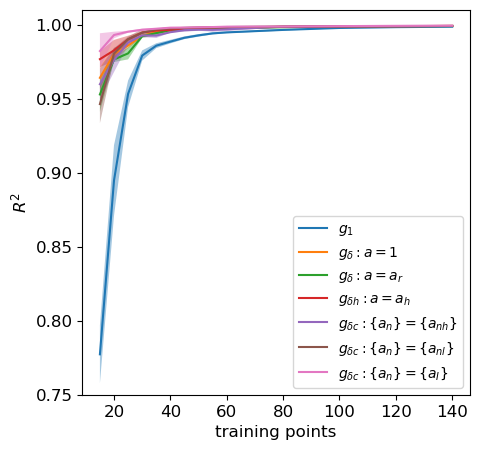

In [391]:
o=0
lim=1
y_lim=[0.75,1.01]
plt.plot(nn[lim:],R2_s.mean(axis=3)[:,lim:,o].T)
plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'])
for i in range(7):
    plt.fill_between(nn[lim:], R2_s.mean(axis=3)[i,lim:,o]+R2_s.std(axis=3)[i,lim:,o], R2_s.mean(axis=3)[i,lim:,o]-R2_s.std(axis=3)[i,lim:,o],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('WeavingDTDiscrepATAT.pdf' )

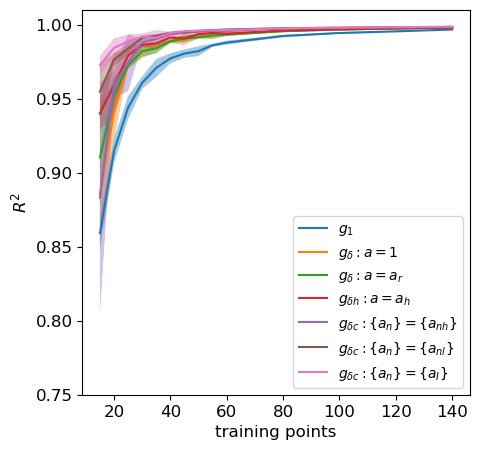

In [392]:
o=1
y_lim=[0.75,1.01]
plt.plot(nn[lim:],R2_s.mean(axis=3)[:,lim:,o].T)
plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'])
for i in range(7):
    plt.fill_between(nn[lim:], R2_s.mean(axis=3)[i,lim:,o]+R2_s.std(axis=3)[i,lim:,o], R2_s.mean(axis=3)[i,lim:,o]-R2_s.std(axis=3)[i,lim:,o],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('WeavingDTDiscrepVTAT.pdf' )

In [393]:
R2_s[:,3].shape

(7, 2, 5)

In [394]:
plt.rcParams["figure.figsize"] = (2,2)

In [395]:
nn

[10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 80, 100, 120, 140]

In [396]:
pd.dataframe(['&','&','&','&','&','&','&'])

AttributeError: module 'pandas' has no attribute 'dataframe'

In [402]:
nn[6]

40

In [403]:
results=pd.DataFrame((R2_s[:,6].mean(axis=2)))

results.index=['\$g_1\$','\$g_{\delta}:a=1\$','\$g_{\delta}:a=a_r\$','\$g_{\delta h}:a=a_h\$','\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$','\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$','\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$']

results.columns=['A_TAT','V_TAT']

results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,A_TAT,V_TAT
\$g_1\$,0.988466,0.977145
\$g_{\delta}:a=1\$,0.995786,0.988301
\$g_{\delta}:a=a_r\$,0.996202,0.988720
\$g_{\delta h}:a=a_h\$,0.996413,0.991275
\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$,0.994823,0.993605
\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$,0.997331,0.994397
\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$,0.997876,0.994373


In [407]:
ISE_save = ISE.reshape(7,len(nn)*reps*y_train.shape[1])

np.savetxt("DiscrepISETrainNVaryDefinitive.csv", ISE_save.detach().numpy(), delimiter=",")

In [408]:
ISE_s=pd.read_csv("DiscrepISETrainNVaryDefinitive.csv",header=None).values.reshape(7,len(nn),y_train.shape[1],reps)

In [409]:
plt.rcParams["figure.figsize"] = (5,5)
fontS=12


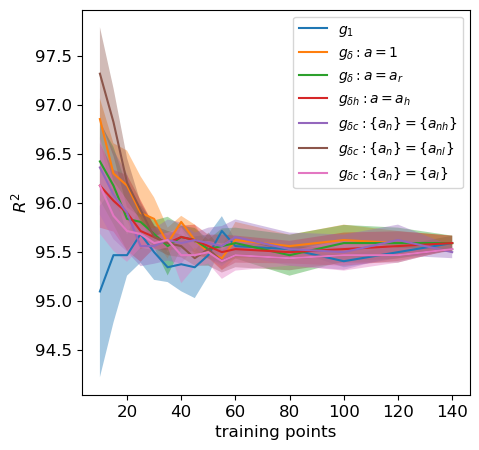

In [413]:
o=0
lim=0
y_lim=[0.75,1.01]
plt.plot(nn[lim:],ISE_s.mean(axis=3)[:,lim:,o].T)
#plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'])
for i in range(7):
    plt.fill_between(nn[lim:], ISE_s.mean(axis=3)[i,lim:,o]+ISE_s.std(axis=3)[i,lim:,o], ISE_s.mean(axis=3)[i,lim:,o]-ISE_s.std(axis=3)[i,lim:,o],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('WeavingDTDiscrepATATISE.pdf' )

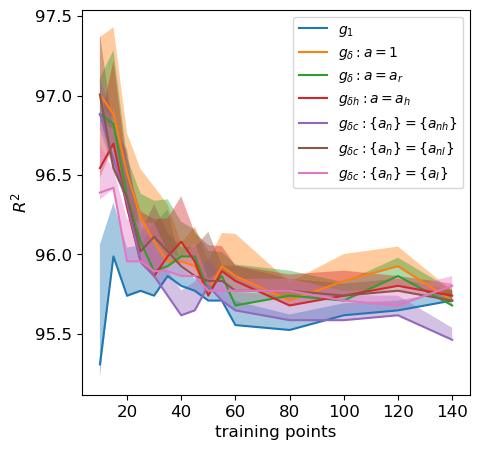

In [414]:
o=1
y_lim=[0.75,1.01]
plt.plot(nn[lim:],ISE_s.mean(axis=3)[:,lim:,o].T)
#plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'])
for i in range(7):
    plt.fill_between(nn[lim:], ISE_s.mean(axis=3)[i,lim:,o]+ISE_s.std(axis=3)[i,lim:,o], ISE_s.mean(axis=3)[i,lim:,o]-R2_s.std(axis=3)[i,lim:,o],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('WeavingDTDiscrepVTATISE.pdf' )

In [393]:
R2_s[:,3].shape

(7, 2, 5)

In [394]:
plt.rcParams["figure.figsize"] = (2,2)

In [395]:
nn

[10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 80, 100, 120, 140]

In [396]:
pd.dataframe(['&','&','&','&','&','&','&'])

AttributeError: module 'pandas' has no attribute 'dataframe'

In [402]:
nn[6]

40

In [403]:
results=pd.DataFrame((R2_s[:,6].mean(axis=2)))

results.index=['\$g_1\$','\$g_{\delta}:a=1\$','\$g_{\delta}:a=a_r\$','\$g_{\delta h}:a=a_h\$','\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$','\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$','\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$']

results.columns=['A_TAT','V_TAT']

results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,A_TAT,V_TAT
\$g_1\$,0.988466,0.977145
\$g_{\delta}:a=1\$,0.995786,0.988301
\$g_{\delta}:a=a_r\$,0.996202,0.988720
\$g_{\delta h}:a=a_h\$,0.996413,0.991275
\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$,0.994823,0.993605
\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$,0.997331,0.994397
\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$,0.997876,0.994373


# Atrial Stiffness

In [17]:
meshes=['01','02','03','04','05','06']

Ys=[]
Xs=[]

for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val+"/X.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values

    

    Xs.append(torch.tensor(inputData[0:200]))
    Ys.append(torch.tensor(outputData[0:200]))

In [18]:
train_input=[]
test_input = []
train_output=[]
test_output = []
emulators=[]

for i in range(len(meshes)):

    X=Xs[i]
    y=Ys[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input.append(X_train)
    test_input.append(X_test)
    train_output.append(y_train)
    test_output.append(y_test)
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    emulators.append(emulator)

0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


In [19]:
reps=5
nn=[10,20,30,40,50,60]
R2=torch.zeros(7,len(nn),7,reps)
ISE=torch.zeros(7,len(nn),7,reps)
Ti=torch.zeros(7,len(nn),reps)

for num, n in enumerate(nn):
    for k in range(len(emulators)):
        emulators2=emulators.copy()
        emulators2.pop(k)
        print(len(emulators2))

        X_train = train_input[k]
        y_train = train_output[k]
        X_test = test_input[k]
        y_test = test_output[k]
        
        for i in range(reps):

            b=np.random.choice(range(X_train.shape[0]),n,replace=False)

            start = time.time()
            model_f=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="linear",training_iter=500)
            end = time.time()
            R2temp,R2std=model_f.R2_sample(X_test,y_test,1000)
            R2[0,num ,:,i]+=R2temp/(len(emulators))
            ISE[0,num,:,i]+=model_f.ISE(X_test,y_test)/(len(emulators))

            Ti[0,num,i]+=(end-start)/(len(emulators))


            em=np.random.randint(len(emulators2))
            start = time.time()
            model_dc_1 = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=torch.tensor([[1],[1],[1],[1],[1],[1],[1]]))
            end = time.time()
            R2temp,R2std=model_dc_1.R2_sample(X_test,y_test,1000)
            R2[1,num ,:,i]+=R2temp/(len(emulators))
            ISE[1,num,:,i]+=model_dc_1.ISE(X_test,y_test)/(len(emulators))
            print(model_dc_1.R2(X_test,y_test))
            print(R2[1])

            Ti[1,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            m0 = emulators2[em].predict(X_train[b,:])
            a_d=np.zeros((y_train.shape[1],1))
            for l in range(y_train.shape[1]):
                result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
                print(result.x)
                a_d[l]=result.x
            a_d=torch.tensor(a_d)
            model_dc_reg = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=a_d)
            end = time.time()
            R2temp,R2std=model_dc_reg.R2_sample(X_test,y_test,1000)
            R2[2,num ,:,i]+=R2temp/(len(emulators))
            ISE[2,num,:,i]+=model_dc_reg.ISE(X_test,y_test)/(len(emulators))

            Ti[2,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            model_dc_learned = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]])
            end = time.time()
            R2temp,R2std=model_dc_learned.R2_sample(X_test,y_test,1000)
            R2[3,num ,:,i]+=R2temp/(len(emulators))
            ISE[3,num,:,i]+=model_dc_learned.ISE(X_test,y_test)/(len(emulators))

            Ti[3,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            model_dc_all = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2)
            end = time.time()
            R2temp,R2std=model_dc_all.R2_sample(X_test,y_test,1000)
            R2[4,num ,:,i]+=R2temp/(len(emulators))
            ISE[4,num,:,i]+=model_dc_all.ISE(X_test,y_test)/(len(emulators))

            Ti[4,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            a_d=torch.zeros((y_train.shape[1],len(emulators2)))
            for j in range(y_train.shape[1]):
                m0=m0_mat(y_train[b],emulators2,X_train[b],j)
                # fit to an order-3 polynomial data
                y_t=(y_train[b,j]-y_train.mean(axis=0)[j])/y_train.std(axis=0)[j]
                model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
                a_d[j]=torch.tensor(model.named_steps['lasso'].coef_)


            model_dc_lasso=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d)
            end = time.time()
            R2temp,R2std=model_dc_lasso.R2_sample(X_test,y_test,1000)
            R2[5,num ,:,i]+=R2temp/(len(emulators))
            ISE[5,num,:,i]+=model_dc_lasso.ISE(X_test,y_test)/(len(emulators))

            Ti[5,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            model_dc_lasso_learned=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d,a_indicator=True)
            end = time.time()
            R2temp,R2std=model_dc_lasso_learned.R2_sample(X_test,y_test,1000)
            R2[6,num ,:,i]+=R2temp/(len(emulators))
            ISE[6,num,:,i]+=model_dc_lasso_learned.ISE(X_test,y_test)/(len(emulators))

            Ti[6,num,i]+=(end-start)/(len(emulators))

5
0
1
2
3
4
5
6


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
tensor([ -9.0876,  -1.7839, -13.9763,  -6.8036,  -5.3839, -28.4096,   0.7142],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.5159,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.2980,  0.0000,  0.0000,  0.0000,  0.0000],
         [-2.3310,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.1354,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.9003,  0.0000,  0.0000,  0.0000,  0.0000],
         [-4.7392,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.1186,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.5460,  0.7232, -0.4243,  0.7317,  0.4467, -0.9929,  0.9197],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.5159,  0.0892,  0.0000,  0.0000,  0.0000],
         [-0.2980,  0.1193,  0.0000,  0.0000,  0.0000],
         [-2.3310, -0.0738,  0.0000,  0.0000,  0.0000],
         [-1.1354,  0.1175,  0.0000,  0.0000,  0.0000],
         [-0.9003,  0.0718,  0.0000,  0.0000,  0.0000],
         [-4.7392, -0.1692,  0.0000,  0.0000,  0.0000],
         [ 0.1186,  0.1523,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([-1.1040, -0.8396, -0.2666,  0.5166,  0.1814, -3.6879,  0.8796],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.5159,  0.0892, -0.1893,  0.0000,  0.0000],
         [-0.2980,  0.1193, -0.1452,  0.0000,  0.0000],
         [-2.3310, -0.0738, -0.0516,  0.0000,  0.0000],
         [-1.1354,  0.1175,  0.0817,  0.0000,  0.0000],
         [-0.9003,  0.0718,  0.0278,  0.0000,  0.0000],
         [-4.7392, -0.1692, -0.6288,  0.0000,  0.0000],
         [ 0.1186,  0.1523,  0.1439,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 2.9886e-02, -9.8268e-01, -7.7263e+00, -8.4969e+01, -2.2269e+00,
        -2.5796e+00, -1.3139e-01], dtype=torch.float64,
       grad_fn=<RsubBackward1>)
tensor([[[-1.5159e+00,  8.9238e-02, -1.8929e-01, -3.1074e-04,  0.0000e+00],
         [-2.9798e-01,  1.1934e-01, -1.4525e-01, -1.6743e-01,  0.0000e+00],
         [-2.3310e+00, -7.3837e-02, -5.1640e-02, -1.2959e+00,  0.0000e+00],
         [-1.1354e+00,  1.1755e-01,  8.1675e-02, -1.4165e+01,  0.0000e+00],
         [-9.0030e-01,  7.1777e-02,  2.7786e-02, -3.7606e-01,  0.0000e+00],
         [-4.7392e+00, -1.6921e-01, -6.2883e-01, -4.3527e-01,  0.0000e+00],
         [ 1.1855e-01,  1.5228e-01,  1.4393e-01, -2.3658e-02,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([-0.1265,  0.6150, -0.2116,  0.6184, -0.1561, -0.0845,  0.6877],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.5159e+00,  8.9238e-02, -1.8929e-01, -3.1074e-04, -2.8553e-02],
         [-2.9798e-01,  1.1934e-01, -1.4525e-01, -1.6743e-01,  8.3507e-02],
         [-2.3310e+00, -7.3837e-02, -5.1640e-02, -1.2959e+00, -3.9182e-02],
         [-1.1354e+00,  1.1755e-01,  8.1675e-02, -1.4165e+01,  9.0978e-02],
         [-9.0030e-01,  7.1777e-02,  2.7786e-02, -3.7606e-01, -3.3002e-02],
         [-4.7392e+00, -1.6921e-01, -6.2883e-01, -4.3527e-01, -2.7121e-02],
         [ 1.1855e-01,  1.5228e-01,  1.4393e-01, -2.3658e-02,  1.1002e-01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([-0.9011, -0.5603, -1.2820,  0.7567,  0.8196, -3.8143,  0.6895],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.6736e+00,  8.9238e-02, -1.8929e-01, -3.1074e-04, -2.8553e-02],
         [-3.9845e-01,  1.1934e-01, -1.4525e-01, -1.6743e-01,  8.3507e-02],
         [-2.5616e+00, -7.3837e-02, -5.1640e-02, -1.2959e+00, -3.9182e-02],
         [-1.0136e+00,  1.1755e-01,  8.1675e-02, -1.4165e+01,  9.0978e-02],
         [-7.7255e-01,  7.1777e-02,  2.7786e-02, -3.7606e-01, -3.3002e-02],
         [-5.3844e+00, -1.6921e-01, -6.2883e-01, -4.3527e-01, -2.7121e-02],
         [ 2.3120e-01,  1.5228e-01,  1.4393e-01, -2.3658e-02,  1.1002e-01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.5147, -0.1967,  0.4627,  0.4926,  0.3607, -0.8251,  0.6441],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.6736e+00,  1.6980e-01, -1.8929e-01, -3.1074e-04, -2.8553e-02],
         [-3.9845e-01,  8.1723e-02, -1.4525e-01, -1.6743e-01,  8.3507e-02],
         [-2.5616e+00, -3.7197e-03, -5.1640e-02, -1.2959e+00, -3.9182e-02],
         [-1.0136e+00,  1.9827e-01,  8.1675e-02, -1.4165e+01,  9.0978e-02],
         [-7.7255e-01,  1.2487e-01,  2.7786e-02, -3.7606e-01, -3.3002e-02],
         [-5.3844e+00, -3.1508e-01, -6.2883e-01, -4.3527e-01, -2.7121e-02],
         [ 2.3120e-01,  2.5773e-01,  1.4393e-01, -2.3658e-02,  1.1002e-01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ -3.3725, -27.0962, -12.8221,  -3.0624,  -4.5058,  -1.8377,   0.3056],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.6736e+00,  1.6980e-01, -7.6336e-01, -3.1074e-04, -2.8553e-02],
         [-3.9845e-01,  8.1723e-02, -4.6718e+00, -1.6743e-01,  8.3507e-02],
         [-2.5616e+00, -3.7197e-03, -2.2151e+00, -1.2959e+00, -3.9182e-02],
         [-1.0136e+00,  1.9827e-01, -4.3525e-01, -1.4165e+01,  9.0978e-02],
         [-7.7255e-01,  1.2487e-01, -7.3310e-01, -3.7606e-01, -3.3002e-02],
         [-5.3844e+00, -3.1508e-01, -9.5026e-01, -4.3527e-01, -2.7121e-02],
         [ 2.3120e-01,  2.5773e-01,  1.9112e-01, -2.3658e-02,  1.1002e-01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ -3.9390,  -7.8289, -45.9384,  -9.2830, -11.6866, -23.0289, -14.8757],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.6736e+00,  1.6980e-01, -7.6336e-01, -7.4473e-01, -2.8553e-02],
         [-3.9845e-01,  8.1723e-02, -4.6718e+00, -1.6129e+00,  8.3507e-02],
         [-2.5616e+00, -3.7197e-03, -2.2151e+00, -9.0295e+00, -3.9182e-02],
         [-1.0136e+00,  1.9827e-01, -4.3525e-01, -1.5751e+01,  9.0978e-02],
         [-7.7255e-01,  1.2487e-01, -7.3310e-01, -2.3574e+00, -3.3002e-02],
         [-5.3844e+00, -3.1508e-01, -9.5026e-01, -4.3203e+00, -2.7121e-02],
         [ 2.3120e-01,  2.5773e-01,  1.9112e-01, -2.5165e+00,  1.1002e-01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([-0.0077, -4.5067, -1.4140,  0.6690, -5.5467, -0.7967, -4.5380],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.6736e+00,  1.6980e-01, -7.6336e-01, -7.4473e-01, -3.7971e-02],
         [-3.9845e-01,  8.1723e-02, -4.6718e+00, -1.6129e+00, -6.7470e-01],
         [-2.5616e+00, -3.7197e-03, -2.2151e+00, -9.0295e+00, -2.9150e-01],
         [-1.0136e+00,  1.9827e-01, -4.3525e-01, -1.5751e+01,  1.9450e-01],
         [-7.7255e-01,  1.2487e-01, -7.3310e-01, -2.3574e+00, -9.7383e-01],
         [-5.3844e+00, -3.1508e-01, -9.5026e-01, -4.3203e+00, -1.7452e-01],
         [ 2.3120e-01,  2.5773e-01,  1.9112e-01, -2.5165e+00, -6.4878e-01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([-1.8201, -0.8780,  0.0804,  0.5079, -5.1852, -0.5305,  0.0234],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.9893e+00,  1.6980e-01, -7.6336e-01, -7.4473e-01, -3.7971e-02],
         [-5.5799e-01,  8.1723e-02, -4.6718e+00, -1.6129e+00, -6.7470e-01],
         [-2.5574e+00, -3.7197e-03, -2.2151e+00, -9.0295e+00, -2.9150e-01],
         [-9.3094e-01,  1.9827e-01, -4.3525e-01, -1.5751e+01,  1.9450e-01],
         [-1.6622e+00,  1.2487e-01, -7.3310e-01, -2.3574e+00, -9.7383e-01],
         [-5.5121e+00, -3.1508e-01, -9.5026e-01, -4.3203e+00, -1.7452e-01],
         [ 2.2975e-01,  2.5773e-01,  1.9112e-01, -2.5165e+00, -6.4878e-01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ -0.5592,  -0.6650,  -0.0874,   0.5549,  -0.5536, -48.9892,  -0.4980],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.9893,   0.0641,  -0.7634,  -0.7447,  -0.0380],
         [ -0.5580,  -0.0368,  -4.6718,  -1.6129,  -0.6747],
         [ -2.5574,  -0.0292,  -2.2151,  -9.0295,  -0.2915],
         [ -0.9309,   0.2890,  -0.4353, -15.7510,   0.1945],
         [ -1.6622,   0.0210,  -0.7331,  -2.3574,  -0.9738],
         [ -5.5121,  -8.5128,  -0.9503,  -4.3203,  -0.1745],
         [  0.2297,   0.1709,   0.1911,  -2.5165,  -0.6488]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([-1.4955, -1.4294,  0.1148,  0.2980, -1.3630, -3.6188, -2.2182],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.9893,   0.0641,  -1.0452,  -0.7447,  -0.0380],
         [ -0.5580,  -0.0368,  -4.9599,  -1.6129,  -0.6747],
         [ -2.5574,  -0.0292,  -2.2142,  -9.0295,  -0.2915],
         [ -0.9309,   0.2890,  -0.4061, -15.7510,   0.1945],
         [ -1.6622,   0.0210,  -0.9823,  -2.3574,  -0.9738],
         [ -5.5121,  -8.5128,  -1.5887,  -4.3203,  -0.1745],
         [  0.2297,   0.1709,  -0.2005,  -2.5165,  -0.6488]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8759, 0.8812, 0.4617, 0.5173, 0.7389, 0.8296, 0.9020],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.9893,   0.0641,  -1.0452,  -0.6012,  -0.0380],
         [ -0.5580,  -0.0368,  -4.9599,  -1.4674,  -0.6747],
         [ -2.5574,  -0.0292,  -2.2142,  -8.9586,  -0.2915],
         [ -0.9309,   0.2890,  -0.4061, -15.6657,   0.1945],
         [ -1.6622,   0.0210,  -0.9823,  -2.2393,  -0.9738],
         [ -5.5121,  -8.5128,  -1.5887,  -4.1893,  -0.1745],
         [  0.2297,   0.1709,  -0.2005,  -2.3671,  -0.6488]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.0101, -2.1094, -5.7402, -2.1136, -1.0794,  0.7227,  0.7524],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.9893,   0.0641,  -1.0452,  -0.6012,  -0.0393],
         [ -0.5580,  -0.0368,  -4.9599,  -1.4674,  -1.0300],
         [ -2.5574,  -0.0292,  -2.2142,  -8.9586,  -1.2533],
         [ -0.9309,   0.2890,  -0.4061, -15.6657,  -0.1989],
         [ -1.6622,   0.0210,  -0.9823,  -2.2393,  -1.1578],
         [ -5.5121,  -8.5128,  -1.5887,  -4.1893,  -0.0557],
         [  0.2297,   0.1709,  -0.2005,  -2.3671,  -0.5255]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.2507, -3.5920, -1.2771, -1.5240, -0.1049,  0.5904, -0.7743],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.9530,   0.0641,  -1.0452,  -0.6012,  -0.0393],
         [ -1.1628,  -0.0368,  -4.9599,  -1.4674,  -1.0300],
         [ -2.7801,  -0.0292,  -2.2142,  -8.9586,  -1.2533],
         [ -1.1951,   0.2890,  -0.4061, -15.6657,  -0.1989],
         [ -1.6912,   0.0210,  -0.9823,  -2.2393,  -1.1578],
         [ -5.4192,  -8.5128,  -1.5887,  -4.1893,  -0.0557],
         [  0.0974,   0.1709,  -0.2005,  -2.3671,  -0.5255]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.00

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ -4.4481, -15.6362,  -5.2597,  -7.6927, -10.4462,  -0.7631,  -2.3826],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.9530,  -0.6824,  -1.0452,  -0.6012,  -0.0393],
         [ -1.1628,  -2.6534,  -4.9599,  -1.4674,  -1.0300],
         [ -2.7801,  -0.9098,  -2.2142,  -8.9586,  -1.2533],
         [ -1.1951,  -0.9967,  -0.4061, -15.6657,  -0.1989],
         [ -1.6912,  -1.7323,  -0.9823,  -2.2393,  -1.1578],
         [ -5.4192,  -8.6466,  -1.5887,  -4.1893,  -0.0557],
         [  0.0974,  -0.2318,  -0.2005,  -2.3671,  -0.5255]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([-1.1429e+02, -3.3096e+01, -4.1948e+02, -6.2976e+00,  2.4170e-01,
        -4.2526e+01, -5.3397e+01], dtype=torch.float64,
       grad_fn=<RsubBackward1>)
tensor([[[-1.9530e+00, -6.8238e-01, -2.0111e+01, -6.0120e-01, -3.9328e-02],
         [-1.1628e+00, -2.6534e+00, -1.0484e+01, -1.4674e+00, -1.0300e+00],
         [-2.7801e+00, -9.0976e-01, -7.2283e+01, -8.9586e+00, -1.2533e+00],
         [-1.1951e+00, -9.9669e-01, -1.4569e+00, -1.5666e+01, -1.9887e-01],
         [-1.6912e+00, -1.7323e+00, -9.4971e-01, -2.2393e+00, -1.1578e+00],
         [-5.4192e+00, -8.6466e+00, -8.7190e+00, -4.1893e+00, -5.5703e-02],
         [ 9.7369e-02, -2.3182e-01, -9.0961e+00, -2.3671e+00, -5.2546e-01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.1938, -0.4693,  0.6190,  0.5562,  0.5081,  0.3070,  0.8376],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.9530e+00, -6.8238e-01, -2.0111e+01, -5.9788e-01, -3.9328e-02],
         [-1.1628e+00, -2.6534e+00, -1.0484e+01, -1.5772e+00, -1.0300e+00],
         [-2.7801e+00, -9.0976e-01, -7.2283e+01, -8.8736e+00, -1.2533e+00],
         [-1.1951e+00, -9.9669e-01, -1.4569e+00, -1.5581e+01, -1.9887e-01],
         [-1.6912e+00, -1.7323e+00, -9.4971e-01, -2.1775e+00, -1.1578e+00],
         [-5.4192e+00, -8.6466e+00, -8.7190e+00, -4.1631e+00, -5.5703e-02],
         [ 9.7369e-02, -2.3182e-01, -9.0961e+00, -2.2306e+00, -5.2546e-01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ -2.1043,  -1.4666,  -2.1456, -13.0647,  -4.6588,  -3.6519,  -5.0345],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.9530,  -0.6824, -20.1109,  -0.5979,  -0.3950],
         [ -1.1628,  -2.6534, -10.4843,  -1.5772,  -1.2840],
         [ -2.7801,  -0.9098, -72.2828,  -8.8736,  -1.6200],
         [ -1.1951,  -0.9967,  -1.4569, -15.5815,  -2.3964],
         [ -1.6912,  -1.7323,  -0.9497,  -2.1775,  -1.9525],
         [ -5.4192,  -8.6466,  -8.7190,  -4.1631,  -0.6713],
         [  0.0974,  -0.2318,  -9.0961,  -2.2306,  -1.3710]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.7856, -0.1464, -0.4788, -0.4424,  0.6392,  0.4986,  0.8500],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.8233,  -0.6824, -20.1109,  -0.5979,  -0.3950],
         [ -1.1877,  -2.6534, -10.4843,  -1.5772,  -1.2840],
         [ -2.8644,  -0.9098, -72.2828,  -8.8736,  -1.6200],
         [ -1.2723,  -0.9967,  -1.4569, -15.5815,  -2.3964],
         [ -1.5888,  -1.7323,  -0.9497,  -2.1775,  -1.9525],
         [ -5.3403,  -8.6466,  -8.7190,  -4.1631,  -0.6713],
         [  0.2379,  -0.2318,  -9.0961,  -2.2306,  -1.3710]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.00

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([-3.5449, -3.9422, -6.4219, -0.1840, -0.7939, -2.9104,  0.2943],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.8233,  -1.3061, -20.1109,  -0.5979,  -0.3950],
         [ -1.1877,  -3.3354, -10.4843,  -1.5772,  -1.2840],
         [ -2.8644,  -2.0310, -72.2828,  -8.8736,  -1.6200],
         [ -1.2723,  -1.0388,  -1.4569, -15.5815,  -2.3964],
         [ -1.5888,  -1.8891,  -0.9497,  -2.1775,  -1.9525],
         [ -5.3403,  -9.1803,  -8.7190,  -4.1631,  -0.6713],
         [  0.2379,  -0.1890,  -9.0961,  -2.2306,  -1.3710]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.0134,  0.4340, -3.0033, -1.6794, -0.3272,  0.4908,  0.9357],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.8233,  -1.3061, -20.1128,  -0.5979,  -0.3950],
         [ -1.1877,  -3.3354, -10.4144,  -1.5772,  -1.2840],
         [ -2.8644,  -2.0310, -72.7936,  -8.8736,  -1.6200],
         [ -1.2723,  -1.0388,  -1.7385, -15.5815,  -2.3964],
         [ -1.5888,  -1.8891,  -1.0156,  -2.1775,  -1.9525],
         [ -5.3403,  -9.1803,  -8.6396,  -4.1631,  -0.6713],
         [  0.2379,  -0.1890,  -8.9415,  -2.2306,  -1.3710]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ -6.7260,   0.3728,  -2.8444,   0.5183,  -6.7835, -80.8901,  -2.4390],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.8233,  -1.3061, -20.1128,  -1.7299,  -0.3950],
         [ -1.1877,  -3.3354, -10.4144,  -1.5197,  -1.2840],
         [ -2.8644,  -2.0310, -72.7936,  -9.3572,  -1.6200],
         [ -1.2723,  -1.0388,  -1.7385, -15.4982,  -2.3964],
         [ -1.5888,  -1.8891,  -1.0156,  -3.3190,  -1.9525],
         [ -5.3403,  -9.1803,  -8.6396, -17.6866,  -0.6713],
         [  0.2379,  -0.1890,  -8.9415,  -2.6413,  -1.3710]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.2933,  0.1265, -3.6262, -2.7459, -5.8919, -0.6997,  0.4026],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.8233,  -1.3061, -20.1128,  -1.7299,  -0.3805],
         [ -1.1877,  -3.3354, -10.4144,  -1.5197,  -1.2777],
         [ -2.8644,  -2.0310, -72.7936,  -9.3572,  -2.3357],
         [ -1.2723,  -1.0388,  -1.7385, -15.4982,  -2.8747],
         [ -1.5888,  -1.8891,  -1.0156,  -3.3190,  -2.9550],
         [ -5.3403,  -9.1803,  -8.6396, -17.6866,  -0.8475],
         [  0.2379,  -0.1890,  -8.9415,  -2.6413,  -1.3194]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.6805,  0.4406, -0.3171,  0.8583, -9.5466, -1.4022,  0.6088],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.3061, -20.1128,  -1.7299,  -0.3805],
         [ -1.1192,  -3.3354, -10.4144,  -1.5197,  -1.2777],
         [ -2.9225,  -2.0310, -72.7936,  -9.3572,  -2.3357],
         [ -1.1343,  -1.0388,  -1.7385, -15.4982,  -2.8747],
         [ -3.1955,  -1.8891,  -1.0156,  -3.3190,  -2.9550],
         [ -5.5799,  -9.1803,  -8.6396, -17.6866,  -0.8475],
         [  0.3381,  -0.1890,  -8.9415,  -2.6413,  -1.3194]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.00

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.7626,  0.6268, -0.0332,  0.3281, -4.1906, -1.2206,  0.2983],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.1128,  -1.7299,  -0.3805],
         [ -1.1192,  -3.2352, -10.4144,  -1.5197,  -1.2777],
         [ -2.9225,  -2.0566, -72.7936,  -9.3572,  -2.3357],
         [ -1.1343,  -0.9854,  -1.7385, -15.4982,  -2.8747],
         [ -3.1955,  -2.6328,  -1.0156,  -3.3190,  -2.9550],
         [ -5.5799,  -9.3941,  -8.6396, -17.6866,  -0.8475],
         [  0.3381,  -0.1431,  -8.9415,  -2.6413,  -1.3194]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ -5.2869,  -2.6783,  -6.1776,  -1.6678,  -0.3701, -24.8489,  -4.3627],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -1.7299,  -0.3805],
         [ -1.1192,  -3.2352, -10.8636,  -1.5197,  -1.2777],
         [ -2.9225,  -2.0566, -73.8253,  -9.3572,  -2.3357],
         [ -1.1343,  -0.9854,  -2.0169, -15.4982,  -2.8747],
         [ -3.1955,  -2.6328,  -1.0915,  -3.3190,  -2.9550],
         [ -5.5799,  -9.3941, -12.7869, -17.6866,  -0.8475],
         [  0.3381,  -0.1431,  -9.6709,  -2.6413,  -1.3194]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ -8.1717,  -0.6281, -31.2821,  -7.4206,  -5.4186,  -1.7935,  -3.8388],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -0.3805],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.2777],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -2.3357],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -2.8747],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9550],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -0.8475],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.3194]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([-6.7244, -0.9733, -5.6126, -1.5493, -0.0678, -4.6641, -0.8753],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8407, 0.8562, 0.8567, 0.8610, 0.6903, 0.6076, 0.9493],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.1365,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.1396,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.1344,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.1378,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.1128,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0884,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.1567,   0.0000,   0.0000,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7549, 0.4645, 0.7203, 0.8640, 0.6839, 0.7537, 0.9336],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.1365,   0.1224,   0.0000,   0.0000,   0.0000],
         [  0.1396,   0.0748,   0.0000,   0.0000,   0.0000],
         [  0.1344,   0.1160,   0.0000,   0.0000,   0.0000],
         [  0.1378,   0.1406,   0.0000,   0.0000,   0.0000],
         [  0.1128,   0.1114,   0.0000,   0.0000,   0.0000],
         [  0.0884,   0.1194,   0.0000,   0.0000,   0.0000],
         [  0.1567,   0.1537,   0.0000,   0.0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.3667,  0.4313,  0.2338,  0.5438,  0.5501, -0.2800,  0.9027],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 1.3647e-01,  1.2243e-01,  4.4471e-02,  0.0000e+00,  0.0000e+00],
         [ 1.3964e-01,  7.4815e-02,  4.4581e-02,  0.0000e+00,  0.0000e+00],
         [ 1.3443e-01,  1.1603e-01, -5.1384e-03,  0.0000e+00,  0.0000e+00],
         [ 1.3778e-01,  1.4057e-01,  5.8175e-02,  0.0000e+00,  0.0000e+

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8749, 0.7657, 0.8487, 0.9103, 0.7130, 0.7869, 0.9638],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 1.3647e-01,  1.2243e-01,  4.4471e-02,  1.3846e-01,  0.0000e+00],
         [ 1.3964e-01,  7.4815e-02,  4.4581e-02,  1.1398e-01,  0.0000e+00],
         [ 1.3443e-01,  1.1603e-01, -5.1384e-03,  1.3440e-01,  0.0000e+00],
         [ 1.3778e-01,  1.4057e-01,  5.8175e-02,  1.4664e-01,  0.0000e+00],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7660, 0.7687, 0.5146, 0.7317, 0.6976, 0.7185, 0.9459],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 1.3647e-01,  1.2243e-01,  4.4471e-02,  1.3846e-01,  1.1880e-01],
         [ 1.3964e-01,  7.4815e-02,  4.4581e-02,  1.1398e-01,  1.1427e-01],
         [ 1.3443e-01,  1.1603e-01, -5.1384e-03,  1.3440e-01,  7.7610e-02],
         [ 1.3778e-01,  1.4057e-01,  5.8175e-02,  1.4664e-01,  1.0748e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.8296,  0.9020, -0.7002,  0.8115,  0.5256,  0.6164,  0.9526],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 2.6966e-01,  1.2243e-01,  4.4471e-02,  1.3846e-01,  1.1880e-01],
         [ 2.8038e-01,  7.4815e-02,  4.4581e-02,  1.1398e-01,  1.1427e-01],
         [-3.2841e-03,  1.1603e-01, -5.1384e-03,  1.3440e-01,  7.7610e-02],
         [ 2.7086e-01,  1.4057e-01,  5.8175e-02,  1.4664e-01,  1.0748

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7548, 0.4550, 0.7461, 0.6447, 0.7267, 0.5476, 0.8277],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 2.6966e-01,  2.3537e-01,  4.4471e-02,  1.3846e-01,  1.1880e-01],
         [ 2.8038e-01,  1.3773e-01,  4.4581e-02,  1.1398e-01,  1.1427e-01],
         [-3.2841e-03,  2.2478e-01, -5.1384e-03,  1.3440e-01,  7.7610e-02],
         [ 2.7086e-01,  2.1950e-01,  5.8175e-02,  1.4664e-01,  1.0748e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.0781,  0.3257, -0.0357,  0.7626,  0.2667, -0.5539,  0.7664],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 2.6966e-01,  2.3537e-01,  3.3457e-02,  1.3846e-01,  1.1880e-01],
         [ 2.8038e-01,  1.3773e-01,  8.0757e-02,  1.1398e-01,  1.1427e-01],
         [-3.2841e-03,  2.2478e-01, -4.7600e-02,  1.3440e-01,  7.7610e-02],
         [ 2.7086e-01,  2.1950e-01,  1.6940e-01,  1.4664e-01,  1.0748e-

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.4250,  0.6683,  0.1773,  0.8247, -0.6545,  0.2295,  0.8998],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 2.6966e-01,  2.3537e-01,  3.3457e-02,  1.5817e-01,  1.1880e-01],
         [ 2.8038e-01,  1.3773e-01,  8.0757e-02,  1.8391e-01,  1.1427e-01],
         [-3.2841e-03,  2.2478e-01, -4.7600e-02,  1.0439e-01,  7.7610e-02],
         [ 2.7086e-01,  2.1950e-01,  1.6940e-01,  2.7009e-01,  1.0748e-

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.6968, 0.7176, 0.6032, 0.7515, 0.6070, 0.5912, 0.9045],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 2.6966e-01,  2.3537e-01,  3.3457e-02,  1.5817e-01,  2.2860e-01],
         [ 2.8038e-01,  1.3773e-01,  8.0757e-02,  1.8391e-01,  2.3139e-01],
         [-3.2841e-03,  2.2478e-01, -4.7600e-02,  1.0439e-01,  1.5891e-01],
         [ 2.7086e-01,  2.1950e-01,  1.6940e-01,  2.7009e-01,  2.2826e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8382, 0.6012, 0.6842, 0.7191, 0.7742, 0.6989, 0.9555],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 4.0517e-01,  2.3537e-01,  3.3457e-02,  1.5817e-01,  2.2860e-01],
         [ 3.7544e-01,  1.3773e-01,  8.0757e-02,  1.8391e-01,  2.3139e-01],
         [ 1.0124e-01,  2.2478e-01, -4.7600e-02,  1.0439e-01,  1.5891e-01],
         [ 3.8276e-01,  2.1950e-01,  1.6940e-01,  2.7009e-01,  2.2826e-01],


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8923, 0.8154, 0.8694, 0.9536, 0.6640, 0.8303, 0.9440],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 4.0517e-01,  3.7885e-01,  3.3457e-02,  1.5817e-01,  2.2860e-01],
         [ 3.7544e-01,  2.6410e-01,  8.0757e-02,  1.8391e-01,  2.3139e-01],
         [ 1.0124e-01,  3.6795e-01, -4.7600e-02,  1.0439e-01,  1.5891e-01],
         [ 3.8276e-01,  3.7623e-01,  1.6940e-01,  2.7009e-01,  2.2826e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9437, 0.9495, 0.6459, 0.8545, 0.3448, 0.7684, 0.9483],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 4.0517e-01,  3.7885e-01,  1.8725e-01,  1.5817e-01,  2.2860e-01],
         [ 3.7544e-01,  2.6410e-01,  2.3618e-01,  1.8391e-01,  2.3139e-01],
         [ 1.0124e-01,  3.6795e-01,  4.7080e-02,  1.0439e-01,  1.5891e-01],
         [ 3.8276e-01,  3.7623e-01,  3.0460e-01,  2.7009e-01,  2.2826e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8307, 0.1125, 0.6815, 0.8036, 0.3758, 0.7595, 0.9240],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 4.0517e-01,  3.7885e-01,  1.8725e-01,  2.8369e-01,  2.2860e-01],
         [ 3.7544e-01,  2.6410e-01,  2.3618e-01,  1.7121e-01,  2.3139e-01],
         [ 1.0124e-01,  3.6795e-01,  4.7080e-02,  2.0329e-01,  1.5891e-01],
         [ 3.8276e-01,  3.7623e-01,  3.0460e-01,  3.8475e-01,  2.2826e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.6981, 0.6090, 0.9006, 0.8804, 0.7662, 0.6590, 0.8878],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 4.0517e-01,  3.7885e-01,  1.8725e-01,  2.8369e-01,  3.2987e-01],
         [ 3.7544e-01,  2.6410e-01,  2.3618e-01,  1.7121e-01,  3.2470e-01],
         [ 1.0124e-01,  3.6795e-01,  4.7080e-02,  2.0329e-01,  2.9649e-01],
         [ 3.8276e-01,  3.7623e-01,  3.0460e-01,  3.8475e-01,  3.6533e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.1684,  0.6066, -0.7596,  0.5446,  0.6013, -0.7934,  0.9494],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 4.0990e-01,  3.7885e-01,  1.8725e-01,  2.8369e-01,  3.2987e-01],
         [ 4.4917e-01,  2.6410e-01,  2.3618e-01,  1.7121e-01,  3.2470e-01],
         [-6.1993e-02,  3.6795e-01,  4.7080e-02,  2.0329e-01,  2.9649e-01],
         [ 4.5284e-01,  3.7623e-01,  3.0460e-01,  3.8475e-01,  3.6533

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.5111, 0.6064, 0.4446, 0.5019, 0.6149, 0.5240, 0.9459],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 4.0990e-01,  4.4555e-01,  1.8725e-01,  2.8369e-01,  3.2987e-01],
         [ 4.4917e-01,  3.4504e-01,  2.3618e-01,  1.7121e-01,  3.2470e-01],
         [-6.1993e-02,  4.3197e-01,  4.7080e-02,  2.0329e-01,  2.9649e-01],
         [ 4.5284e-01,  4.4103e-01,  3.0460e-01,  3.8475e-01,  3.6533e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.2987, 0.8613, 0.4983, 0.7361, 0.5682, 0.2564, 0.9723],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 4.0990e-01,  4.4555e-01,  2.2406e-01,  2.8369e-01,  3.2987e-01],
         [ 4.4917e-01,  3.4504e-01,  3.6306e-01,  1.7121e-01,  3.2470e-01],
         [-6.1993e-02,  4.3197e-01,  9.6470e-02,  2.0329e-01,  2.9649e-01],
         [ 4.5284e-01,  4.4103e-01,  4.1571e-01,  3.8475e-01,  3.6533e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.6672, -0.0646,  0.5902,  0.7543,  0.8379,  0.7791,  0.8015],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 4.0990e-01,  4.4555e-01,  2.2406e-01,  3.7162e-01,  3.2987e-01],
         [ 4.4917e-01,  3.4504e-01,  3.6306e-01,  7.6302e-02,  3.2470e-01],
         [-6.1993e-02,  4.3197e-01,  9.6470e-02,  2.8790e-01,  2.9649e-01],
         [ 4.5284e-01,  4.4103e-01,  4.1571e-01,  5.0056e-01,  3.6533e-

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.6561,  0.7694,  0.5410, -0.3339,  0.5072,  0.4655,  0.9534],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 4.0990e-01,  4.4555e-01,  2.2406e-01,  3.7162e-01,  4.2975e-01],
         [ 4.4917e-01,  3.4504e-01,  3.6306e-01,  7.6302e-02,  4.4281e-01],
         [-6.1993e-02,  4.3197e-01,  9.6470e-02,  2.8790e-01,  3.6956e-01],
         [ 4.5284e-01,  4.4103e-01,  4.1571e-01,  5.0056e-01,  2.8579e-

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7798, 0.8675, 0.5377, 0.6201, 0.6789, 0.7009, 0.9577],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 5.2571e-01,  4.4555e-01,  2.2406e-01,  3.7162e-01,  4.2975e-01],
         [ 5.8241e-01,  3.4504e-01,  3.6306e-01,  7.6302e-02,  4.4281e-01],
         [-9.4632e-03,  4.3197e-01,  9.6470e-02,  2.8790e-01,  3.6956e-01],
         [ 5.4544e-01,  4.4103e-01,  4.1571e-01,  5.0056e-01,  2.8579e-01],


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8174, 0.7679, 0.0915, 0.7960, 0.6468, 0.5616, 0.8881],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 5.2571e-01,  5.7165e-01,  2.2406e-01,  3.7162e-01,  4.2975e-01],
         [ 5.8241e-01,  4.5116e-01,  3.6306e-01,  7.6302e-02,  4.4281e-01],
         [-9.4632e-03,  3.9527e-01,  9.6470e-02,  2.8790e-01,  3.6956e-01],
         [ 5.4544e-01,  5.6237e-01,  4.1571e-01,  5.0056e-01,  2.8579e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.6760,  0.8462, -1.7127,  0.8133,  0.8059, -0.0206,  0.9167],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 5.2571e-01,  5.7165e-01,  3.2971e-01,  3.7162e-01,  4.2975e-01],
         [ 5.8241e-01,  4.5116e-01,  4.8956e-01,  7.6302e-02,  4.4281e-01],
         [-9.4632e-03,  3.9527e-01, -3.2967e-01,  2.8790e-01,  3.6956e-01],
         [ 5.4544e-01,  5.6237e-01,  5.4350e-01,  5.0056e-01,  2.8579e-

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.3742,  0.4867, -0.3117,  0.5371,  0.7218,  0.5683,  0.8573],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 5.2571e-01,  5.7165e-01,  3.2971e-01,  4.0932e-01,  4.2975e-01],
         [ 5.8241e-01,  4.5116e-01,  4.8956e-01,  1.4858e-01,  4.4281e-01],
         [-9.4632e-03,  3.9527e-01, -3.2967e-01,  2.0320e-01,  3.6956e-01],
         [ 5.4544e-01,  5.6237e-01,  5.4350e-01,  5.7459e-01,  2.8579e-

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.6629, 0.7896, 0.0682, 0.7391, 0.7131, 0.4323, 0.8616],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 5.2571e-01,  5.7165e-01,  3.2971e-01,  4.0932e-01,  5.2554e-01],
         [ 5.8241e-01,  4.5116e-01,  4.8956e-01,  1.4858e-01,  5.6294e-01],
         [-9.4632e-03,  3.9527e-01, -3.2967e-01,  2.0320e-01,  3.0674e-01],
         [ 5.4544e-01,  5.6237e-01,  5.4350e-01,  5.7459e-01,  3.8597e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.6715,  0.3942,  0.6644,  0.7423, -0.2034,  0.1459,  0.9222],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.5716,   0.3297,   0.4093,   0.5255],
         [  0.6315,   0.4512,   0.4896,   0.1486,   0.5629],
         [  0.0954,   0.3953,  -0.3297,   0.2032,   0.3067],
         [  0.6531,   0.5624,   0.5435,   0.5746,   0.3860],
         [  0.4433,   0.4978,   0.3198,   0.2160,   0.4745],
         [  0.2356,   0.4622,  -0.2396,   0.4300,   0.3791],
         [  0.9316,   0.7399,   0.73

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9372, 0.8511, 0.6386, 0.9472, 0.7328, 0.8174, 0.9275],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.3297,   0.4093,   0.5255],
         [  0.6315,   0.5897,   0.4896,   0.1486,   0.5629],
         [  0.0954,   0.4934,  -0.3297,   0.2032,   0.3067],
         [  0.6531,   0.7175,   0.5435,   0.5746,   0.3860],
         [  0.4433,   0.5996,   0.3198,   0.2160,   0.4745],
         [  0.2356,   0.5903,  -0.2396,   0.4300,   0.3791],
         [  0.9316,   0.8929,   0.7326,   0.7

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7161, 0.5245, 0.7043, 0.4398, 0.4714, 0.6571, 0.8375],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.4093,   0.5255],
         [  0.6315,   0.5897,   0.5674,   0.1486,   0.5629],
         [  0.0954,   0.4934,  -0.2213,   0.2032,   0.3067],
         [  0.6531,   0.7175,   0.5954,   0.5746,   0.3860],
         [  0.4433,   0.5996,   0.3831,   0.2160,   0.4745],
         [  0.2356,   0.5903,  -0.1425,   0.4300,   0.3791],
         [  0.9316,   0.8929,   0.8679,   0.7

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7606, 0.6734, 0.8773, 0.8804, 0.2730, 0.7063, 0.8900],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.5255],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.5629],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.3067],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.3860],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.4745],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.3791],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8968, 0.8808, 0.8821, 0.9282, 0.8509, 0.7390, 0.9516],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8659, 0.7132, 0.8775, 0.9047, 0.8301, 0.8224, 0.9806],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.4312, 0.6101, 0.5821, 0.7286, 0.5345, 0.0747, 0.9264],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.6766, 0.4777, 0.5617, 0.8664, 0.7949, 0.6991, 0.9361],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8972, 0.9246, 0.8116, 0.8852, 0.8163, 0.5208, 0.9693],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7586, 0.8113, 0.6494, 0.6613, 0.7570, 0.7395, 0.9407],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8818, 0.8916, 0.6957, 0.8023, 0.7004, 0.7234, 0.9560],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7631, 0.8514, 0.7868, 0.8971, 0.8165, 0.6077, 0.8484],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8535, 0.9623, 0.6337, 0.9282, 0.8549, 0.7184, 0.9483],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.6256, 0.5669, 0.5602, 0.7934, 0.6893, 0.7779, 0.8514],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7696, 0.8001, 0.7304, 0.8206, 0.6600, 0.6552, 0.8729],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8970, 0.8681, 0.8340, 0.8871, 0.7740, 0.8329, 0.9772],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9358, 0.9520, 0.8415, 0.9765, 0.8965, 0.8365, 0.9491],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9388, 0.8896, 0.8950, 0.9436, 0.7592, 0.7619, 0.9562],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9460, 0.8948, 0.9334, 0.9670, 0.8605, 0.7076, 0.9725],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9035, 0.8833, 0.8340, 0.8959, 0.6427, 0.8438, 0.9515],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7846, 0.4582, 0.6865, 0.8027, 0.7330, 0.7809, 0.9141],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8828, 0.7505, 0.7856, 0.7402, 0.7088, 0.7364, 0.9298],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8284, 0.8763, 0.6891, 0.7373, 0.8632, 0.7571, 0.9387],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.6010, 0.8621, 0.6451, 0.7577, 0.8380, 0.6135, 0.9496],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8139, 0.6923, 0.6506, 0.7958, 0.6478, 0.7022, 0.8843],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8899, 0.8646, 0.6525, 0.6838, 0.6684, 0.7922, 0.9455],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7495, 0.7657, 0.4465, 0.6535, 0.7659, 0.7676, 0.9555],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8875, 0.8644, 0.5530, 0.7559, 0.7293, 0.5365, 0.9534],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8849, 0.7556, 0.2045, 0.7464, 0.8242, 0.6258, 0.9241],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7472, 0.8157, 0.0197, 0.7700, 0.8376, 0.1727, 0.9324],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8563, 0.8728, 0.8491, 0.9598, 0.7814, 0.5975, 0.9390],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8451, 0.8123, 0.8038, 0.9498, 0.8026, 0.7412, 0.9417],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8919, 0.9105, 0.7759, 0.9650, 0.6966, 0.8110, 0.9378],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9048, 0.8746, 0.8677, 0.9388, 0.6948, 0.7206, 0.9571],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8881, 0.9362, 0.8678, 0.9634, 0.6328, 0.8068, 0.9374],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8821, 0.8030, 0.7893, 0.8902, 0.8130, 0.6531, 0.9837],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8459, 0.6204, 0.6580, 0.7786, 0.7405, 0.6394, 0.9817],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7762, 0.6460, 0.7654, 0.8369, 0.7645, 0.6749, 0.9659],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8754, 0.6701, 0.8301, 0.7386, 0.6955, 0.8707, 0.9025],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8272, 0.8212, 0.8554, 0.9076, 0.8491, 0.6894, 0.9647],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7471, 0.8150, 0.5597, 0.8766, 0.7443, 0.4945, 0.9504],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7208, 0.7975, 0.6325, 0.9152, 0.6481, 0.7954, 0.8773],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8336, 0.6900, 0.2576, 0.9205, 0.6379, 0.4932, 0.9465],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.6729,  0.7127,  0.5581,  0.8255, -0.0858,  0.4825,  0.9104],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7899, 0.9357, 0.6255, 0.9289, 0.8528, 0.6551, 0.9258],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9215, 0.9048, 0.8395, 0.8882, 0.6720, 0.7227, 0.9669],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8966, 0.8777, 0.8338, 0.9410, 0.7592, 0.5569, 0.9796],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9388, 0.9548, 0.9482, 0.9563, 0.8474, 0.8698, 0.9786],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.7148e+00, -1.1841e+00, -2.0996e+01, -3.0956e+00, -1.5254e+00],
         [-1.1192e+00, -3.2352e+00, -1.0864e+01, -1.6272e+00, -1.4525e+00],
         [-2.9225e+00, -2.0566e+00, -7.3825e+01, -1.4582e+01, -3.2874e+00],
         [-1.1343e+00, -9.8539e-01, -2.0169e+00, -1.6740e+01, -3.1631e+00],
         [-3.1955e+00, -2.6328e+00, -1.0915e+00, -4.2357e+00, -2.9870e+00],
         [-5.5799e+00, -9.3941e+00, -1.2787e+01, -1.7994e+01, -1.6477e+00],
         [ 3.3806e-01, -1.4310e-01, -9.6709e+00, -3.2836e+00, -1.4765e+00]],

        [[ 6.2678e-01,  7.2484e-01,  4.3697e-01,  5.2936e-01,  6.7263e-01],
         [ 6.3152e-01,  5.8972e-01,  5.6745e-01,  2.5268e-01,  7.0835e-01],
         [ 9.5386e-02,  4.9341e-01, -2.2128e-01,  3.4601e-01,  4.5045e-01],
         [ 6.5308e-01,  7.1745e-01,  5.9535e-01,  7.1745e-01,  5.3870e-01],
  

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9408, 0.8868, 0.8796, 0.9344, 0.7678, 0.9228, 0.9739],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9277, 0.9086, 0.8626, 0.9608, 0.8255, 0.5757, 0.9123],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.6574, 0.5335, 0.5840, 0.5033, 0.7611, 0.7750, 0.8505],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7612, 0.8426, 0.6719, 0.6566, 0.8428, 0.7043, 0.9269],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8437, 0.7370, 0.4112, 0.6966, 0.8271, 0.8030, 0.7944],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8433, 0.7009, 0.7140, 0.7563, 0.8496, 0.7949, 0.8810],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8703, 0.8498, 0.7000, 0.8475, 0.8297, 0.7976, 0.9102],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9121, 0.8876, 0.0917, 0.7827, 0.7452, 0.7784, 0.9531],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8221, 0.6911, 0.4338, 0.8052, 0.8685, 0.8728, 0.9755],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.6437,  0.8770, -0.6170,  0.5033,  0.7834, -0.0225,  0.8938],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8380, 0.8962, 0.6583, 0.8188, 0.8839, 0.7864, 0.9550],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8967, 0.8894, 0.3246, 0.7778, 0.8211, 0.8017, 0.9692],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9136, 0.8877, 0.8599, 0.9594, 0.8850, 0.6797, 0.9576],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9211, 0.8084, 0.8836, 0.9404, 0.7674, 0.7024, 0.9636],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8800, 0.9101, 0.8664, 0.9538, 0.7922, 0.6765, 0.9406],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9129, 0.9043, 0.8113, 0.9452, 0.8733, 0.7227, 0.9422],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8535, 0.8436, 0.9108, 0.9591, 0.8956, 0.7707, 0.9156],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8855, 0.8176, 0.8288, 0.8050, 0.6423, 0.8823, 0.9229],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7940, 0.6968, 0.8296, 0.9011, 0.7206, 0.6797, 0.9681],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9276, 0.9355, 0.8680, 0.8689, 0.8303, 0.7225, 0.9730],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8648, 0.8771, 0.8692, 0.8907, 0.8513, 0.7876, 0.9735],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8742, 0.7305, 0.8052, 0.7648, 0.7940, 0.8244, 0.9455],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8037, 0.7728, 0.1496, 0.9090, 0.4923, 0.6627, 0.9439],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.4785, 0.8069, 0.6953, 0.8843, 0.5938, 0.6016, 0.8683],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9217, 0.8838, 0.7838, 0.9449, 0.8898, 0.7927, 0.9630],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9130, 0.9132, 0.6214, 0.9190, 0.6309, 0.8741, 0.9564],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.6476, 0.7283, 0.6222, 0.9455, 0.5774, 0.6756, 0.9303],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9321, 0.9617, 0.9561, 0.9701, 0.8813, 0.7059, 0.9747],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8618, 0.8806, 0.8387, 0.9127, 0.7860, 0.7471, 0.9628],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9635, 0.9356, 0.9254, 0.9050, 0.8506, 0.7500, 0.9738],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9322, 0.9020, 0.9179, 0.9221, 0.8237, 0.8816, 0.9723],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9231, 0.9594, 0.9430, 0.9554, 0.8807, 0.6535, 0.9687],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9058, 0.8791, 0.8254, 0.8439, 0.7407, 0.8363, 0.9590],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8708, 0.8667, 0.6422, 0.7566, 0.7731, 0.7915, 0.9556],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7790, 0.7896, 0.6752, 0.8307, 0.7662, 0.7288, 0.8985],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8484, 0.8473, 0.7571, 0.7663, 0.8260, 0.7962, 0.9284],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.4437, 0.6643, 0.5929, 0.5677, 0.8554, 0.8594, 0.9172],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8436, 0.9141, 0.3575, 0.8357, 0.8574, 0.7864, 0.9619],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8263, 0.8331, 0.3773, 0.8068, 0.7855, 0.5587, 0.9378],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9011, 0.8841, 0.6477, 0.8548, 0.9106, 0.5827, 0.9700],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9122, 0.8611, 0.6632, 0.7556, 0.9065, 0.7588, 0.9548],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([ 0.7919,  0.8241, -0.1020,  0.8204,  0.8519,  0.2925,  0.9574],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8939, 0.9550, 0.8510, 0.9681, 0.7083, 0.8007, 0.9484],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9335, 0.8380, 0.7493, 0.9330, 0.8402, 0.8886, 0.9687],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8906, 0.8447, 0.8426, 0.9067, 0.7858, 0.7290, 0.9437],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9060, 0.9369, 0.8868, 0.9657, 0.7350, 0.8217, 0.9528],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8844, 0.9433, 0.9041, 0.9735, 0.7028, 0.8086, 0.9340],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8728, 0.9153, 0.8630, 0.8319, 0.8264, 0.7043, 0.9771],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8723, 0.9115, 0.8815, 0.9195, 0.8450, 0.7514, 0.9730],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9379, 0.8965, 0.7646, 0.9062, 0.8170, 0.7045, 0.9836],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8580, 0.6717, 0.7962, 0.9009, 0.8173, 0.8519, 0.9441],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8404, 0.7868, 0.8903, 0.8487, 0.8615, 0.7610, 0.9646],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8692, 0.9458, 0.8122, 0.9507, 0.8837, 0.8627, 0.9186],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8472, 0.8876, 0.6595, 0.9373, 0.6208, 0.8549, 0.9770],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7600, 0.8732, 0.7608, 0.9008, 0.6590, 0.7201, 0.9243],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7981, 0.9232, 0.5931, 0.9096, 0.6309, 0.6734, 0.9682],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9245, 0.9515, 0.8180, 0.9361, 0.8820, 0.8545, 0.9695],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8923, 0.9210, 0.9267, 0.9175, 0.8643, 0.7922, 0.9437],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9649, 0.9521, 0.9092, 0.9262, 0.7820, 0.8836, 0.9738],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9358, 0.9560, 0.8056, 0.9536, 0.7708, 0.8939, 0.9574],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9473, 0.9542, 0.9306, 0.9561, 0.8789, 0.8096, 0.9719],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9376, 0.9421, 0.9056, 0.9346, 0.8130, 0.9006, 0.9777],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8202, 0.8390, 0.8717, 0.8473, 0.8760, 0.7509, 0.9501],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8714, 0.9032, 0.8018, 0.8298, 0.8164, 0.6976, 0.9675],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8421, 0.7956, 0.7134, 0.7725, 0.7844, 0.5895, 0.9612],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.6986, 0.8622, 0.7454, 0.8669, 0.8773, 0.7800, 0.9783],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8634, 0.8190, 0.8260, 0.8389, 0.7849, 0.8943, 0.9487],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8961, 0.8332, 0.5096, 0.7289, 0.8864, 0.8770, 0.9349],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.7922, 0.8592, 0.4868, 0.8406, 0.8783, 0.6149, 0.9601],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9145, 0.8583, 0.6892, 0.8871, 0.8743, 0.8618, 0.9765],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8992, 0.8766, 0.5400, 0.9115, 0.8632, 0.7303, 0.9723],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8760, 0.8772, 0.0378, 0.6912, 0.8610, 0.7559, 0.9728],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9567, 0.8587, 0.8067, 0.9281, 0.5900, 0.8749, 0.9704],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9067, 0.8935, 0.8809, 0.8907, 0.7977, 0.7969, 0.9539],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8891, 0.9157, 0.8950, 0.9405, 0.8916, 0.8023, 0.9625],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8721, 0.7618, 0.9061, 0.9153, 0.5831, 0.6935, 0.9306],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9207, 0.8904, 0.9067, 0.9356, 0.8385, 0.7727, 0.9440],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ -1.7148,  -1.1841, -20.9964,  -3.0956,  -1.5254],
         [ -1.1192,  -3.2352, -10.8636,  -1.6272,  -1.4525],
         [ -2.9225,  -2.0566, -73.8253, -14.5816,  -3.2874],
         [ -1.1343,  -0.9854,  -2.0169, -16.7396,  -3.1631],
         [ -3.1955,  -2.6328,  -1.0915,  -4.2357,  -2.9870],
         [ -5.5799,  -9.3941, -12.7869, -17.9943,  -1.6477],
         [  0.3381,  -0.1431,  -9.6709,  -3.2836,  -1.4765]],

        [[  0.6268,   0.7248,   0.4370,   0.5294,   0.6726],
         [  0.6315,   0.5897,   0.5674,   0.2527,   0.7083],
         [  0.0954,   0.4934,  -0.2213,   0.3460,   0.4504],
         [  0.6531,   0.7175,   0.5954,   0.7175,   0.5387],
         [  0.4433,   0.5996,   0.3831,   0.2421,   0.6080],
         [  0.2356,   0.5903,  -0.1425,   0.5323,   0.4959],
         [  0.9316,   0.8929,   0.8679,   0.8

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
1
2
3
4
5
6


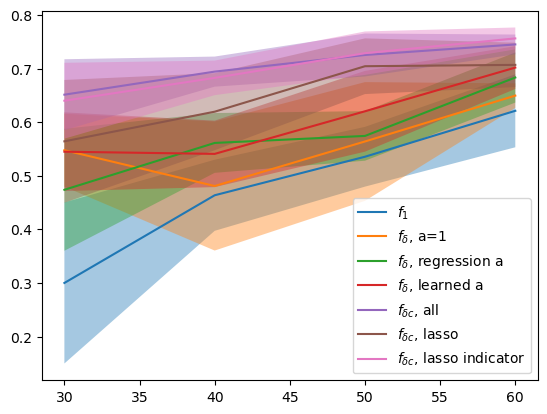

In [22]:
o=2
lim=2
y_lim=[0.7,1.01]
plt.plot(nn[lim:],R2.mean(axis=3)[:,lim:,o].T)
#plt.ylim(y_lim)
plt.legend(['$f_1$','$f_\delta$, a=1','$f_\delta$, regression a','$f_\delta$, learned a','$f_{\delta c}$, all','$f_{\delta c}$, lasso','$f_{\delta c}$, lasso indicator'])
for i in range(7):
    plt.fill_between(nn[lim:], R2.mean(axis=3)[i,lim:,o]+R2.std(axis=3)[i,lim:,o], R2.mean(axis=3)[i,lim:,o]-R2.std(axis=3)[i,lim:,o],alpha=0.4)

In [23]:
R2_save = R2.reshape(7,len(nn)*reps*y_train.shape[1])

np.savetxt("DiscrepR2TrainNVaryDefinitiveAtria.csv", R2_save.detach().numpy(), delimiter=",")